# **ASSIGNMENT 15** #

## ***2. FRAUD DATA*** ##

File : Fraud_check.csv

In [1]:
# import the libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, preprocessing, metrics
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from collections import Counter
from imblearn.over_sampling import SMOTE,  ADASYN


import warnings
warnings.filterwarnings('ignore')
palette_color = sns.color_palette('rainbow')

### **Importing data from file Fraud_check.csv** ###

In [2]:
# Reading the data from the file 'Fraud_check.csv'
fraud_orig_data = pd.read_csv("Fraud_check.csv")
fraud_orig_data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


### **EDA (Exploratory Data Analysis)** ###

In [3]:
fraud_orig_data.shape

(600, 6)

#### *Descriptive Analysis* ####

In [4]:
fraud_orig_data.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


In [5]:
fraud_orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.3+ KB


#### *Checking for missing values* ####

In [6]:
# check for missing values
fraud_orig_data.isna().sum() # The result shows that there are no missing values

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

#### *Checking for Null Values* ####

In [7]:
# Checking to see if there are any null values
# We can get this information using fraud_orig_data.info() option as well
fraud_orig_data.isnull().sum() # The result shows that there are no null values

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

#### *Checking for duplicates* ####

In [8]:
# Checking for Duplicate Values
fraud_orig_data.duplicated()  # if any 2 rows has same values

0      False
1      False
2      False
3      False
4      False
       ...  
595    False
596    False
597    False
598    False
599    False
Length: 600, dtype: bool

In [9]:
# Count of duplicated rows
fraud_orig_data[fraud_orig_data.duplicated()].shape # We see that there are no duplicate

(0, 6)

In [10]:
# Print the duplicated rows. Since we have duplicates it will show us the record
fraud_orig_data[fraud_orig_data.duplicated()] # We don't find any duplicates

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


#### *Checking the data structure* ####

In [11]:
fraud_data = fraud_orig_data.copy() # Creating a replicate 'company_data' of the original DataFrame 'company_orig_data'

In [12]:
# Data Structure
print(type(fraud_data))
fraud_data.shape

<class 'pandas.core.frame.DataFrame'>


(600, 6)

#### *Rename Columns* ####

In [13]:
# Renaming column names
fraud_data.rename(columns = {'Undergrad':'UG','Marital.Status':'MS','Taxable.Income':'TAX','City.Population':'POPU','Work.Experience':'W_EXP','Urban':'URBAN'}, inplace = True)
fraud_data.head()

,UG,MS,TAX,POPU,W_EXP,URBAN
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [14]:
# Checking data types
fraud_data.dtypes # check data types of all variables

UG       object
MS       object
TAX       int64
POPU      int64
W_EXP     int64
URBAN    object
dtype: object

### ***Feature Engineering - Creating a new 'taxable_income' Categorical Column*** ###

***Based on the Assumption*** - Treating those who have taxable_income **<= 30000 as "Risky"** and others i.e., **>30000 as "Good"**

In [15]:
fraud_data

,UG,MS,TAX,POPU,W_EXP,URBAN
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [16]:
fraud_data['TAX'].describe()

count      600.000000
mean     55208.375000
std      26204.827597
min      10003.000000
25%      32871.500000
50%      55074.500000
75%      78611.750000
max      99619.000000
Name: TAX, dtype: float64

In [17]:
fraud_data['TAX_CAT'] = pd.cut(x = fraud_data['TAX'], bins = [0,30000,100000], labels=['Risky','Good'], right = False)
fraud_data.head()

,UG,MS,TAX,POPU,W_EXP,URBAN,TAX_CAT
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


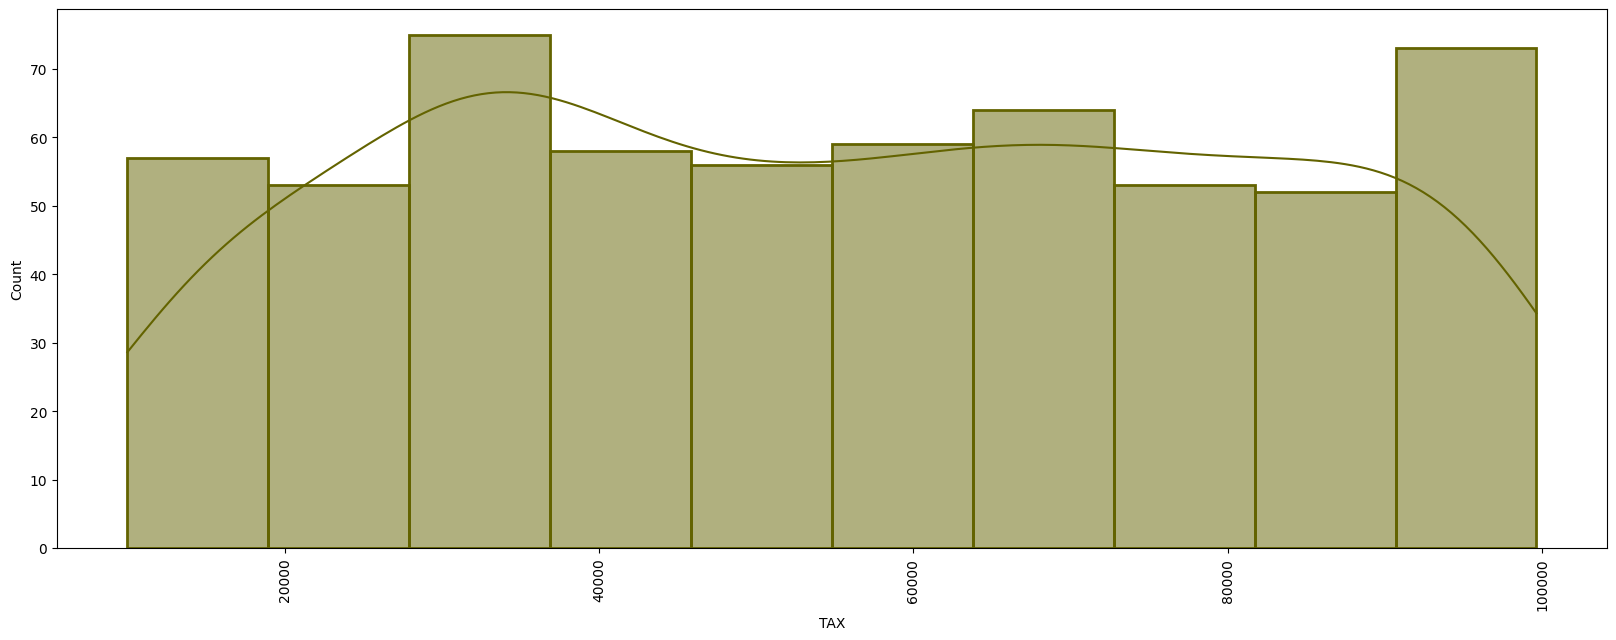

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plotting(df, feature, color):
    plt.figure(figsize=(20,7))
    plot = sns.histplot(df, x=feature, color=color, edgecolor=color, linewidth=2, bins=10, kde=True)
    plt.setp(plot.get_xticklabels(), rotation=90)

plotting(fraud_data,'TAX', '#636300')

<Figure size 2000x600 with 0 Axes>

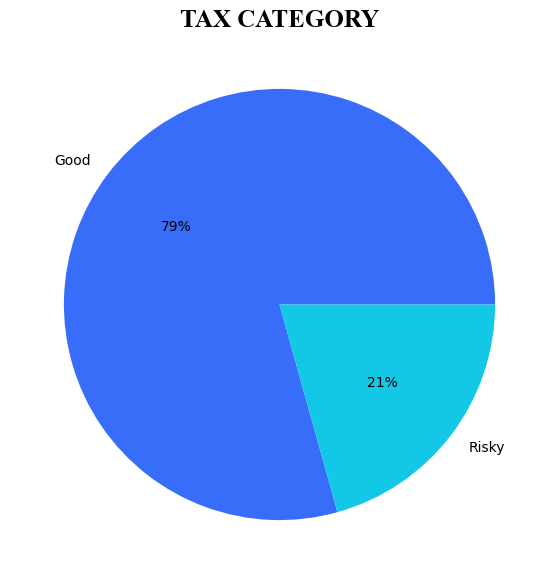

In [19]:
# Display state data in a form of Pie Graph
plt.figure(figsize=(20,6))
plt.figure(figsize=(20,7))
values = fraud_data['TAX_CAT'].value_counts().keys().tolist()
counts = fraud_data['TAX_CAT'].value_counts().tolist()
plt.pie(fraud_data['TAX_CAT'].value_counts(), labels=values, colors=palette_color, autopct='%.0f%%')

plt.title('TAX CATEGORY', weight='bold', fontfamily = "Times New Roman", size = '18')

plt.show()

In [20]:
fraud_data.TAX_CAT.value_counts()

TAX_CAT
Good     476
Risky    124
Name: count, dtype: int64

##### **INFERENCE:** #####
The **Target column is UnBalanced** i.e., 'TAX_CAT' column is not evenly distributed or balanced with 'Good' samples being more i.e., 476 (79%) when compared to 'Risky' with 124 (21%).

#### ***Segregation of columns into Numeric and Non-Numeric*** ####

In [21]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   UG       600 non-null    object  
 1   MS       600 non-null    object  
 2   TAX      600 non-null    int64   
 3   POPU     600 non-null    int64   
 4   W_EXP    600 non-null    int64   
 5   URBAN    600 non-null    object  
 6   TAX_CAT  600 non-null    category
dtypes: category(1), int64(3), object(3)
memory usage: 29.0+ KB


In [22]:
categorical_cols = []
numeric_cols = []
for columns in fraud_data.columns:
      if ((fraud_data[columns].dtypes == 'object') or (fraud_data[columns].dtypes == 'category')):
            categorical_cols.append(columns)
            print(f"There are {len(fraud_data[columns].unique())} unique values in the categorical column name '{columns}'")
      elif ((fraud_data[columns].dtypes != 'object') and (fraud_data[columns].dtypes != 'category')):
            numeric_cols.append(columns)

print("\nThe categorical columns are: ",categorical_cols,"\n")
print("The numeric columns are: ",numeric_cols,"\n")

There are 2 unique values in the categorical column name 'UG'
There are 3 unique values in the categorical column name 'MS'
There are 2 unique values in the categorical column name 'URBAN'
There are 2 unique values in the categorical column name 'TAX_CAT'

The categorical columns are:  ['UG', 'MS', 'URBAN', 'TAX_CAT'] 

The numeric columns are:  ['TAX', 'POPU', 'W_EXP'] 



In [23]:
# Categorical variables
# For columns in company_data.columns:
# If fraud_data[columns].dtypes == 'object' or fraud_data[columns].dtypes == 'category':
for columns in fraud_data[categorical_cols].columns:
        unique_count = len(fraud_data[columns].unique())
        print("\n------------------------------------------")
        print(f"There are {unique_count} unique columns in the column name '{columns}'")
        print("\n",fraud_data[columns].value_counts())


------------------------------------------
There are 2 unique columns in the column name 'UG'

 UG
YES    312
NO     288
Name: count, dtype: int64

------------------------------------------
There are 3 unique columns in the column name 'MS'

 MS
Single      217
Married     194
Divorced    189
Name: count, dtype: int64

------------------------------------------
There are 2 unique columns in the column name 'URBAN'

 URBAN
YES    302
NO     298
Name: count, dtype: int64

------------------------------------------
There are 2 unique columns in the column name 'TAX_CAT'

 TAX_CAT
Good     476
Risky    124
Name: count, dtype: int64


In [24]:
fraud_data[numeric_cols].head()

,TAX,POPU,W_EXP
0,68833,50047,10
1,33700,134075,18
2,36925,160205,30
3,50190,193264,15
4,81002,27533,28


In [25]:
fraud_data[categorical_cols].head()

,UG,MS,URBAN,TAX_CAT
0,NO,Single,YES,Good
1,YES,Divorced,YES,Good
2,NO,Married,YES,Good
3,YES,Single,YES,Good
4,NO,Married,NO,Good


In [26]:
# Creating dataframes for both categorical data as well as numeric data
fraud_cat_comp_data = pd.DataFrame()
fraud_num_comp_data = pd.DataFrame()

fraud_cat_comp_data = fraud_data[categorical_cols]
fraud_num_comp_data = fraud_data[numeric_cols]

print(f"The numerical data is - \n{fraud_num_comp_data.head()}\n\nThe categorical data is - \n{fraud_cat_comp_data.head()}")

The numerical data is - 
     TAX    POPU  W_EXP
0  68833   50047     10
1  33700  134075     18
2  36925  160205     30
3  50190  193264     15
4  81002   27533     28

The categorical data is - 
    UG        MS URBAN TAX_CAT
0   NO    Single   YES    Good
1  YES  Divorced   YES    Good
2   NO   Married   YES    Good
3  YES    Single   YES    Good
4   NO   Married    NO    Good


In [27]:
fraud_num_comp_data.head()

,TAX,POPU,W_EXP
0,68833,50047,10
1,33700,134075,18
2,36925,160205,30
3,50190,193264,15
4,81002,27533,28


In [28]:
fraud_cat_comp_data

,UG,MS,URBAN,TAX_CAT
0,NO,Single,YES,Good
1,YES,Divorced,YES,Good
2,NO,Married,YES,Good
3,YES,Single,YES,Good
4,NO,Married,NO,Good
...,...,...,...,...
595,YES,Divorced,YES,Good
596,YES,Divorced,YES,Good
597,NO,Divorced,YES,Good
598,YES,Married,NO,Good


### **Visualizations** ###

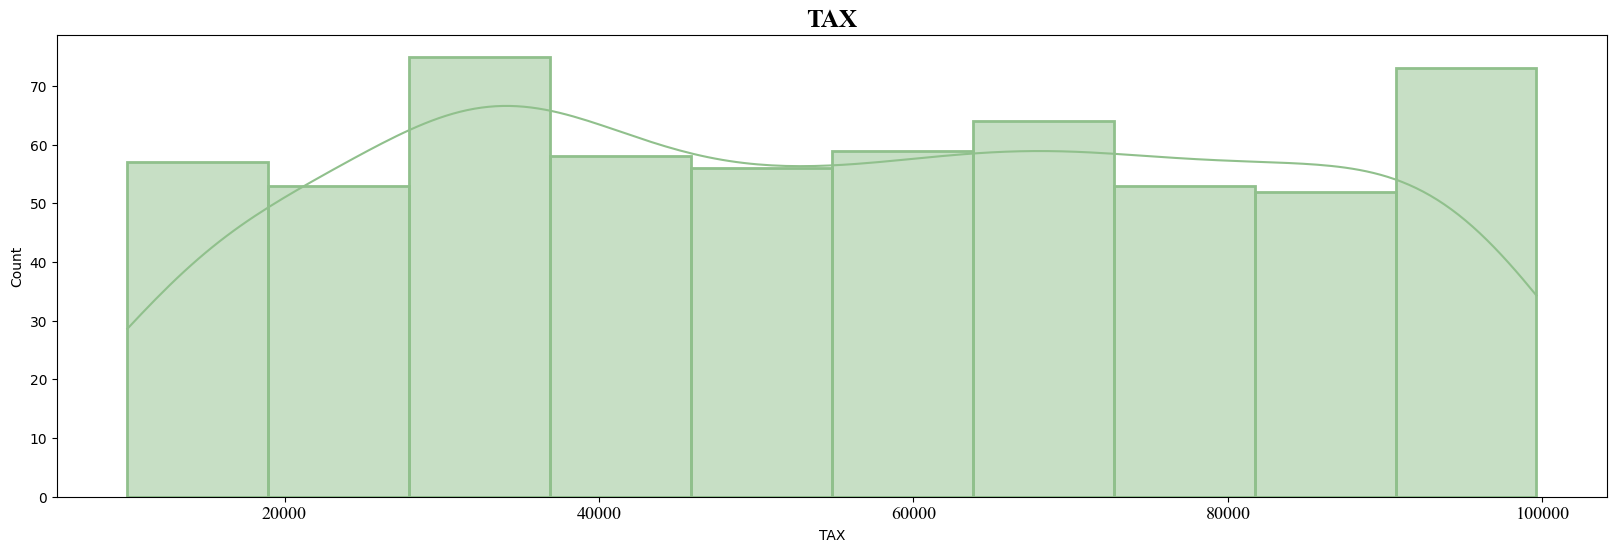

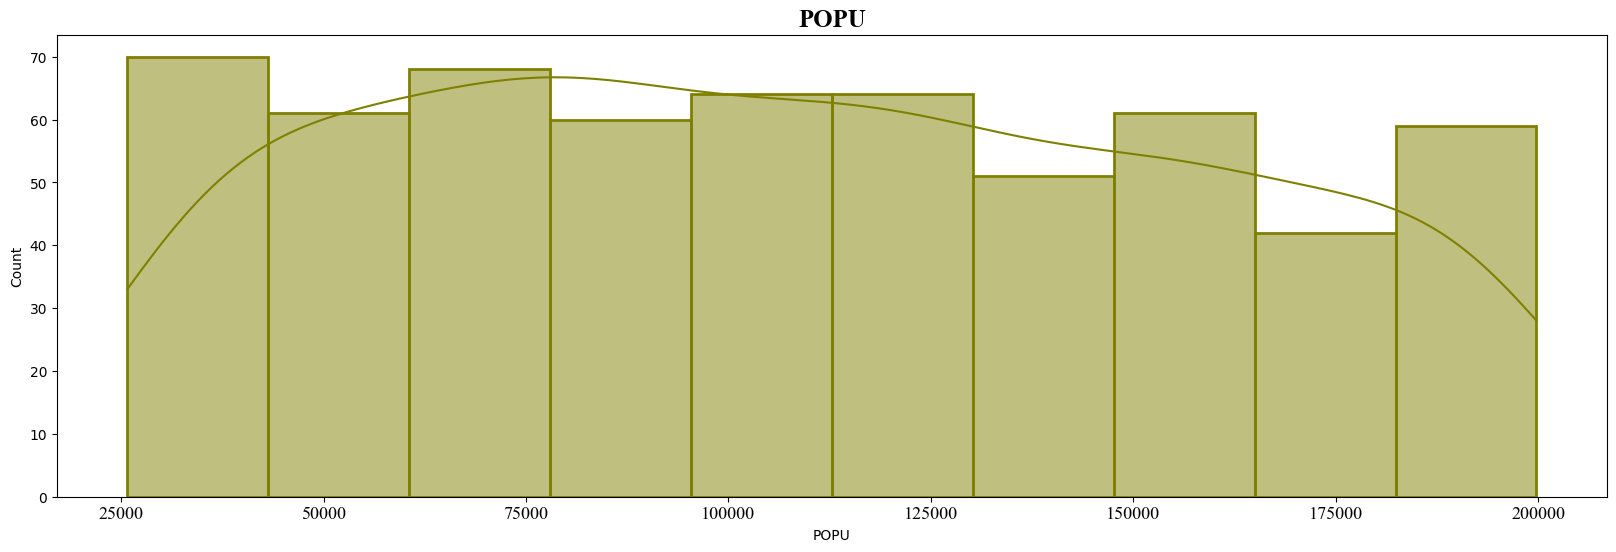

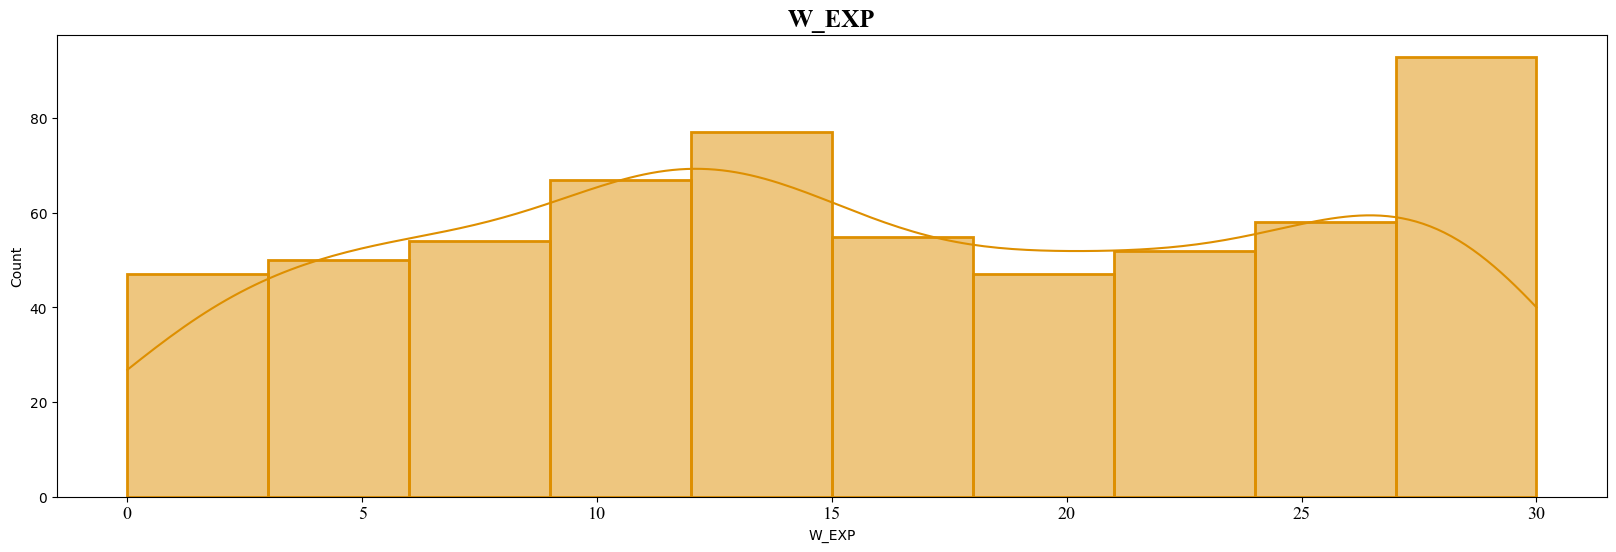

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pylab
def plot_data(data,feature):
    plt.figure(figsize=(20,6))
    plot = sns.histplot(data, x=feature, color=color, edgecolor=color, linewidth=2, bins=10, kde=True)
    plt.setp(plot.get_xticklabels(), rotation=0, fontfamily = "Times New Roman", size = '13')

for n_cols in fraud_num_comp_data:
    colors = ['#4c9a47','#90c08c','#598eff','#636300','#74a3ff','#bebe00','#7ab375','#808000','#0541ff','#9e9e00','#ffc274','#de8f00','#64a65e','#2260ff','#ffb85c','#3e78ff']
    color = random.choice(colors)
    plot_data(fraud_num_comp_data,n_cols)
    plt.title(n_cols, weight='bold', fontfamily = "Times New Roman", size = '18')

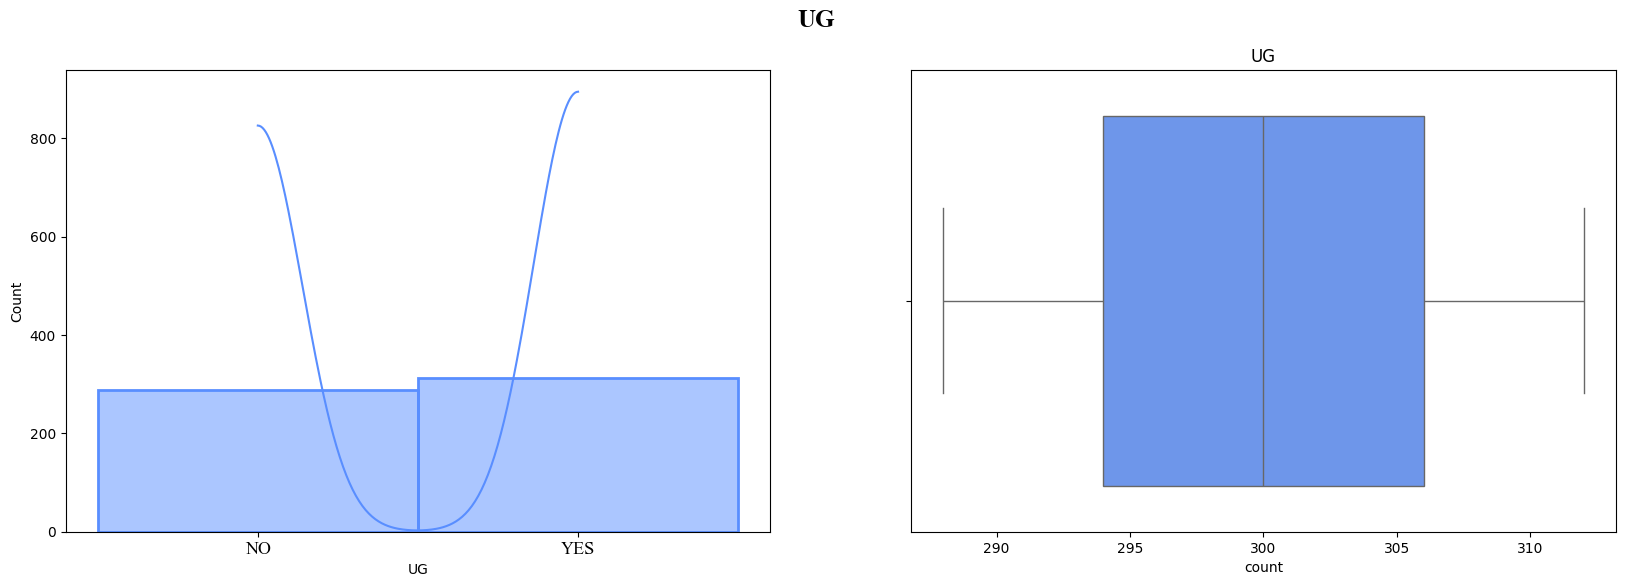

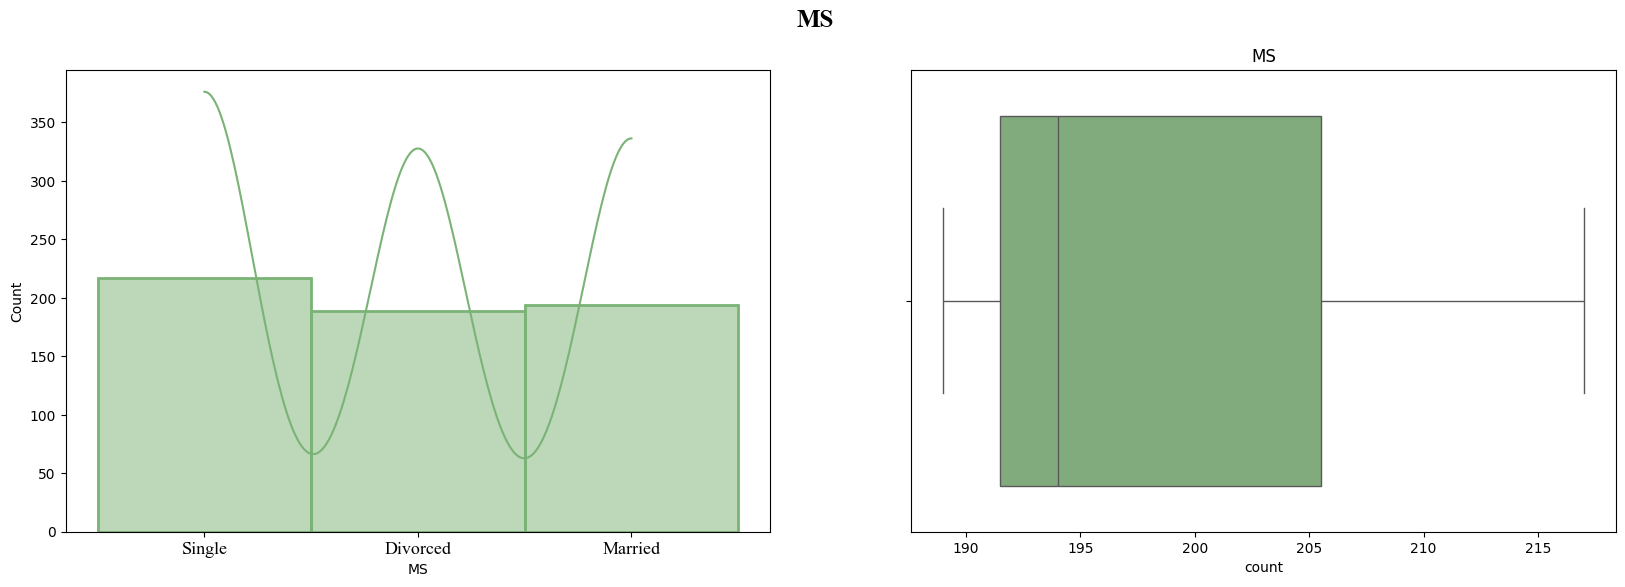

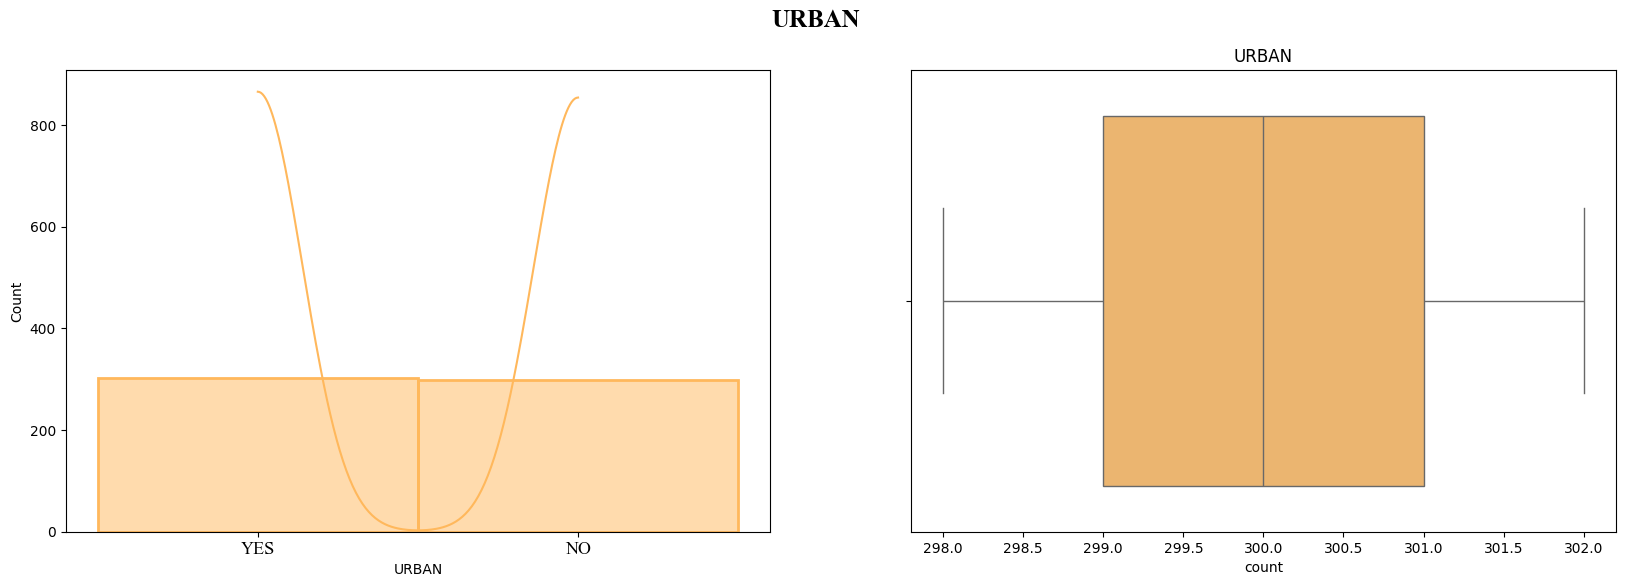

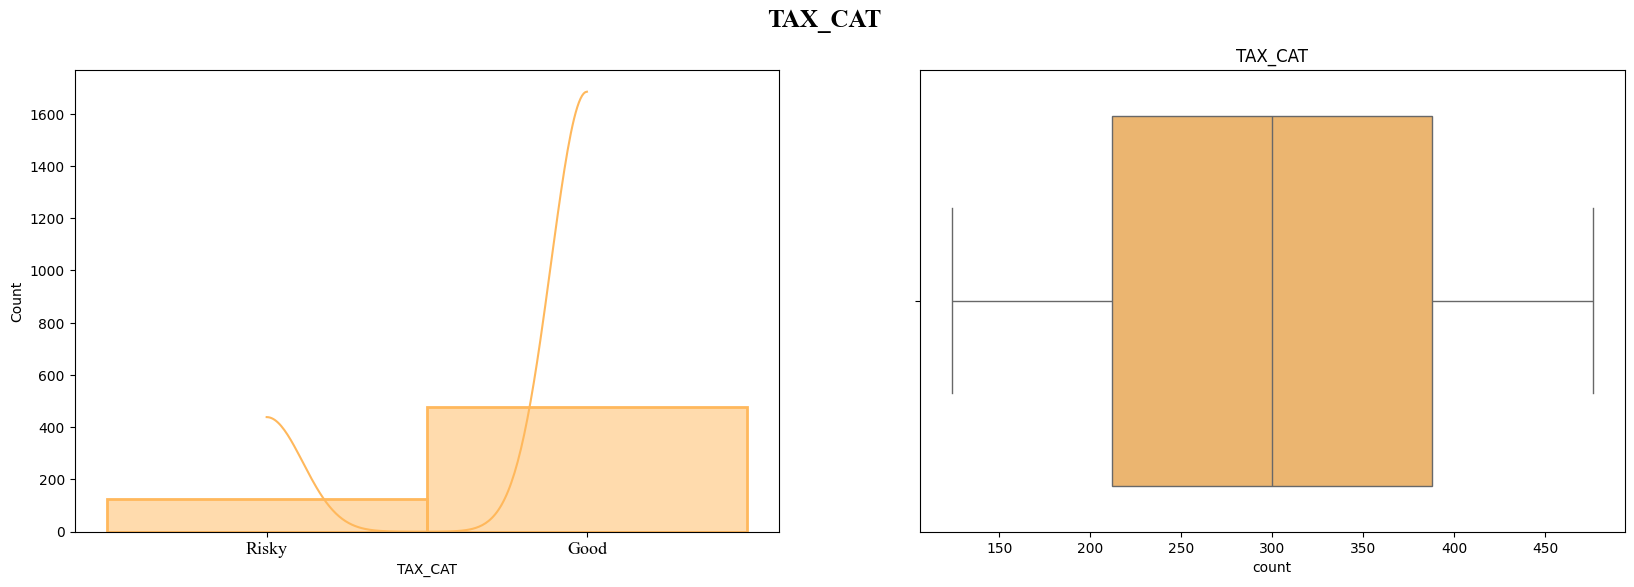

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pylab
def plot_data(data,feature):
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    plot = sns.histplot(data, x=feature, color=color, edgecolor=color, linewidth=2, bins=10, kde=True)
    plt.setp(plot.get_xticklabels(), rotation=0, fontfamily = "Times New Roman", size = '13')

    plt.subplot(1,2,2)
    sns.boxplot(x=data[feature].value_counts(), color=color)
    plt.suptitle(feature.upper(), weight='bold', fontfamily = "Times New Roman", size = '18')

for c_cols in fraud_cat_comp_data:
    colors = ['#4c9a47','#90c08c','#598eff','#636300','#74a3ff','#bebe00','#7ab375','#808000','#0541ff','#9e9e00','#ffc274','#de8f00','#64a65e','#2260ff','#ffb85c','#3e78ff']
    color = random.choice(colors)
    plot_data(fraud_cat_comp_data,c_cols)
    plt.title(c_cols)

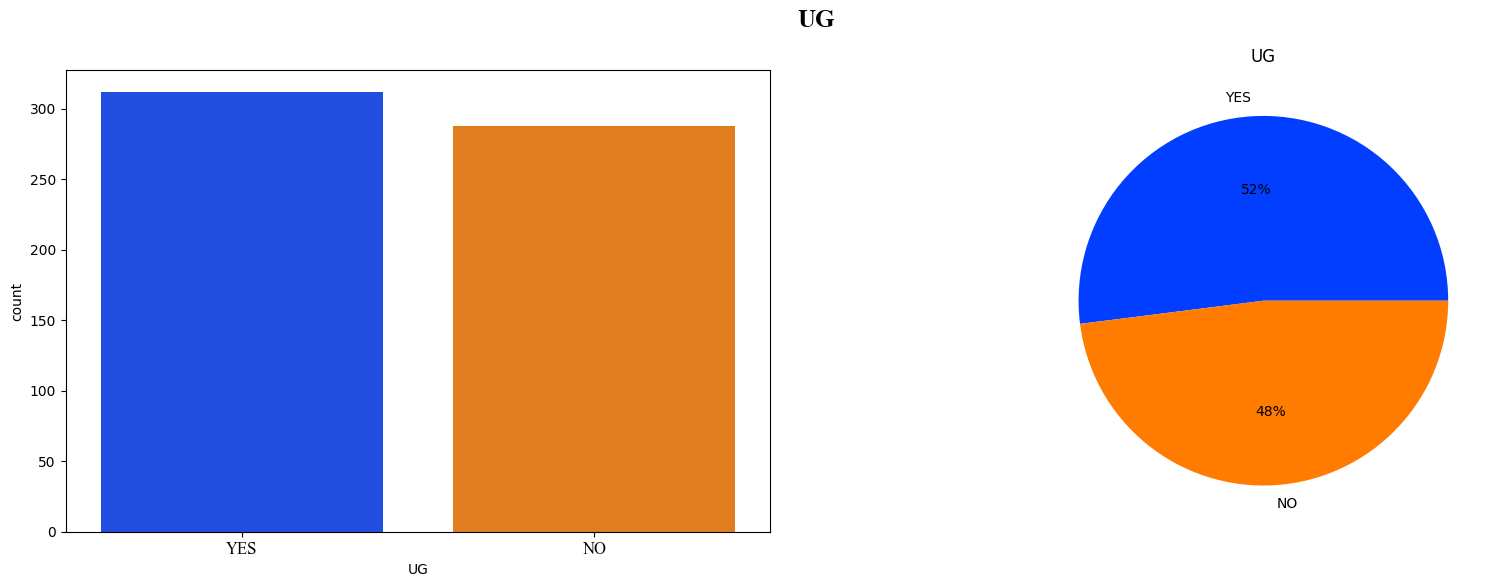

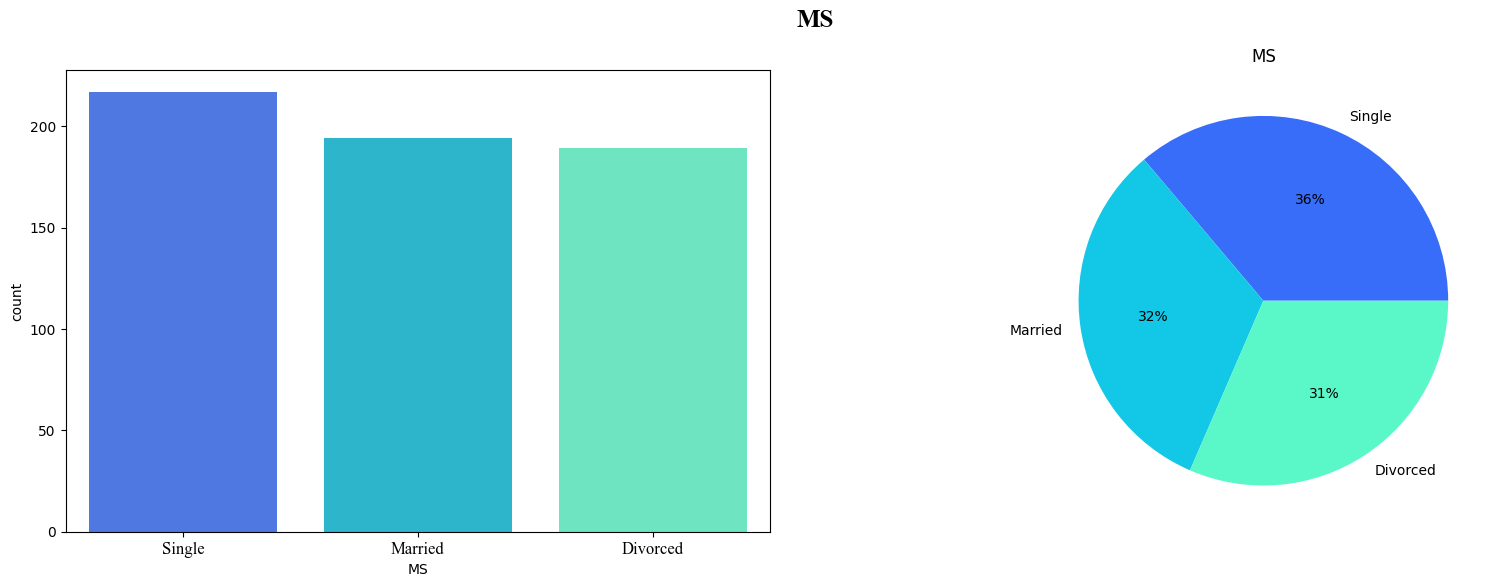

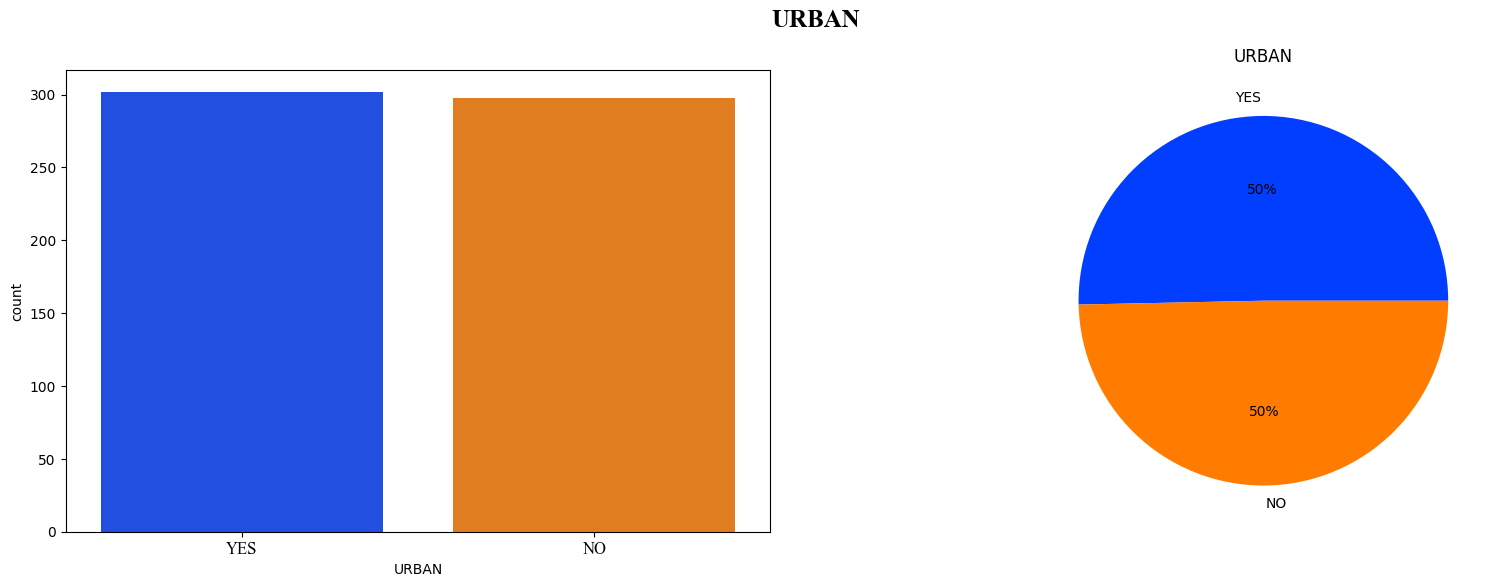

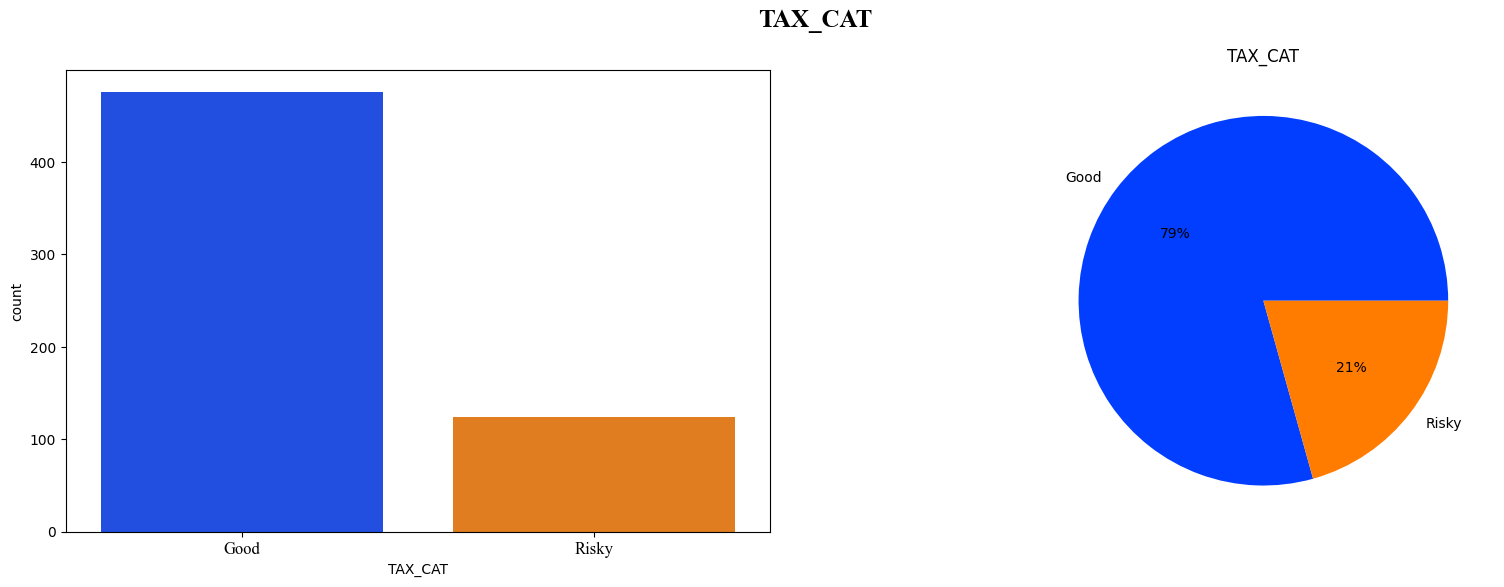

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pylab
def plot_data(data,feature,color):
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    palette_color = sns.color_palette(color)
    sns.countplot(x=feature, data=data, palette = palette_color, order=data[feature].value_counts().index)
    plt.xticks(rotation = 0,fontsize = 12, fontfamily = "Times New Roman")

  
    # Display state data in a form of Pie Graph
    plt.subplot(1,2,2)
    values = data[feature].value_counts().keys().tolist()
    counts = data[feature].value_counts().tolist()
    plt.pie(data[feature].value_counts(), labels=values, colors=palette_color, autopct='%.0f%%')

    plt.suptitle(feature.upper(), weight='bold', fontfamily = "Times New Roman").set_fontsize('18')

for c_cols in fraud_cat_comp_data:
    colors = ['bright','rainbow']
    color = random.choice(colors)
    plot_data(fraud_cat_comp_data,c_cols,color)
    plt.title(c_cols)

### **Label Encoding** ###

In [32]:
fr_data = fraud_data.copy()

In [33]:
fr_data.head()

,UG,MS,TAX,POPU,W_EXP,URBAN,TAX_CAT
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


In [34]:
fraud_cat_comp_data.head()

,UG,MS,URBAN,TAX_CAT
0,NO,Single,YES,Good
1,YES,Divorced,YES,Good
2,NO,Married,YES,Good
3,YES,Single,YES,Good
4,NO,Married,NO,Good


In [35]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

for col in fraud_cat_comp_data:
  fr_data[str(col) + "_n"]= label_encoder.fit_transform(fr_data[col])

In [36]:
# Changing the number of rows to be displayed in a DataFrame
#pd.set_option('display.max_rows', 10)  # Display up to 10 rows
#pd.set_option('display.max_rows', None)  # Show all rows

In [37]:
fr_data

,UG,MS,TAX,POPU,W_EXP,URBAN,TAX_CAT,UG_n,MS_n,URBAN_n,TAX_CAT_n
0,NO,Single,68833,50047,10,YES,Good,0,2,1,0
1,YES,Divorced,33700,134075,18,YES,Good,1,0,1,0
2,NO,Married,36925,160205,30,YES,Good,0,1,1,0
3,YES,Single,50190,193264,15,YES,Good,1,2,1,0
4,NO,Married,81002,27533,28,NO,Good,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES,Good,1,0,1,0
596,YES,Divorced,69967,55369,2,YES,Good,1,0,1,0
597,NO,Divorced,47334,154058,0,YES,Good,0,0,1,0
598,YES,Married,98592,180083,17,NO,Good,1,1,0,0


##### *The Column data for the Categorical columns is decoded by LabelEncoder in the following way:* #####
| **Column Name** | **1st Category** | **2nd Category** | **3rd Category** |
| --- | --- | --- | --- |
| **UG_n** | 0 - NO | 1 - YES | |
| **MS_n** | 0 - Divorced | 1 - Married | 2 - Single |  
| **URBAN_n** | 0 - NO | 1 - YES | |
| **TAX_CAT_n** | 0 - Good | 1 - Risky | | 

In [38]:
fr_data.head()

,UG,MS,TAX,POPU,W_EXP,URBAN,TAX_CAT,UG_n,MS_n,URBAN_n,TAX_CAT_n
0,NO,Single,68833,50047,10,YES,Good,0,2,1,0
1,YES,Divorced,33700,134075,18,YES,Good,1,0,1,0
2,NO,Married,36925,160205,30,YES,Good,0,1,1,0
3,YES,Single,50190,193264,15,YES,Good,1,2,1,0
4,NO,Married,81002,27533,28,NO,Good,0,1,0,0


In [39]:
# Removing the Categorical Columns once we have desciphered the encoding done by LabelEncoder
fr_data = fr_data.drop(['TAX','UG', 'MS','URBAN', 'TAX_CAT'], axis = 'columns')
fr_data

,POPU,W_EXP,UG_n,MS_n,URBAN_n,TAX_CAT_n
0,50047,10,0,2,1,0
1,134075,18,1,0,1,0
2,160205,30,0,1,1,0
3,193264,15,1,2,1,0
4,27533,28,0,1,0,0
...,...,...,...,...,...,...
595,39492,7,1,0,1,0
596,55369,2,1,0,1,0
597,154058,0,0,0,1,0
598,180083,17,1,1,0,0


In [40]:
# After decoded the data we can now only consider the label encoded columns and not the categorical columns and also exclude the target column 'Sales_Categorized_n'
inputs_fraud = fr_data.drop(['TAX_CAT_n'], axis = 'columns')
inputs_fraud

,POPU,W_EXP,UG_n,MS_n,URBAN_n
0,50047,10,0,2,1
1,134075,18,1,0,1
2,160205,30,0,1,1
3,193264,15,1,2,1
4,27533,28,0,1,0
...,...,...,...,...,...
595,39492,7,1,0,1
596,55369,2,1,0,1
597,154058,0,0,0,1
598,180083,17,1,1,0


In [41]:
target_fraud = fr_data['TAX_CAT_n']
target_fraud.head()

0    0
1    0
2    0
3    0
4    0
Name: TAX_CAT_n, dtype: int32

### **Correlation Matrix** ###
Check for Assumption: Independent variables are independent of each other

In [42]:
fr_data.head()

,POPU,W_EXP,UG_n,MS_n,URBAN_n,TAX_CAT_n
0,50047,10,0,2,1,0
1,134075,18,1,0,1,0
2,160205,30,0,1,1,0
3,193264,15,1,2,1,0
4,27533,28,0,1,0,0


In [43]:
fr_data.corr()

,POPU,W_EXP,UG_n,MS_n,URBAN_n,TAX_CAT_n
POPU,1.000000,0.013135,0.079579,-0.001564,-0.040098,0.012225
W_EXP,0.013135,1.000000,-0.005362,-0.002213,-0.094559,-0.001972
UG_n,0.079579,-0.005362,1.000000,0.042407,-0.000267,0.012523
MS_n,-0.001564,-0.002213,0.042407,1.000000,0.064562,0.006081
URBAN_n,-0.040098,-0.094559,-0.000267,0.064562,1.000000,0.004830
TAX_CAT_n,0.012225,-0.001972,0.012523,0.006081,0.004830,1.000000


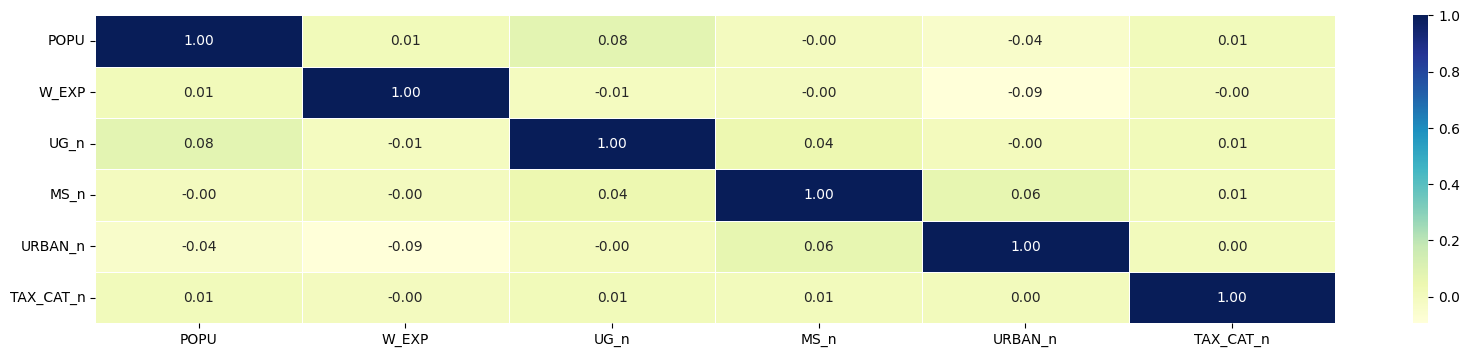

In [44]:
# Correlation Heatmap
f,ax = plt.subplots(figsize=(20,4))
sns.heatmap(fr_data.corr(), annot=True, linewidths =.5, fmt ='.2f',cmap="YlGnBu",ax=ax)
plt.show()

Based on the heatmap we see very less correlation between the individual entities. So the issue of colinearity problem will not arise. 

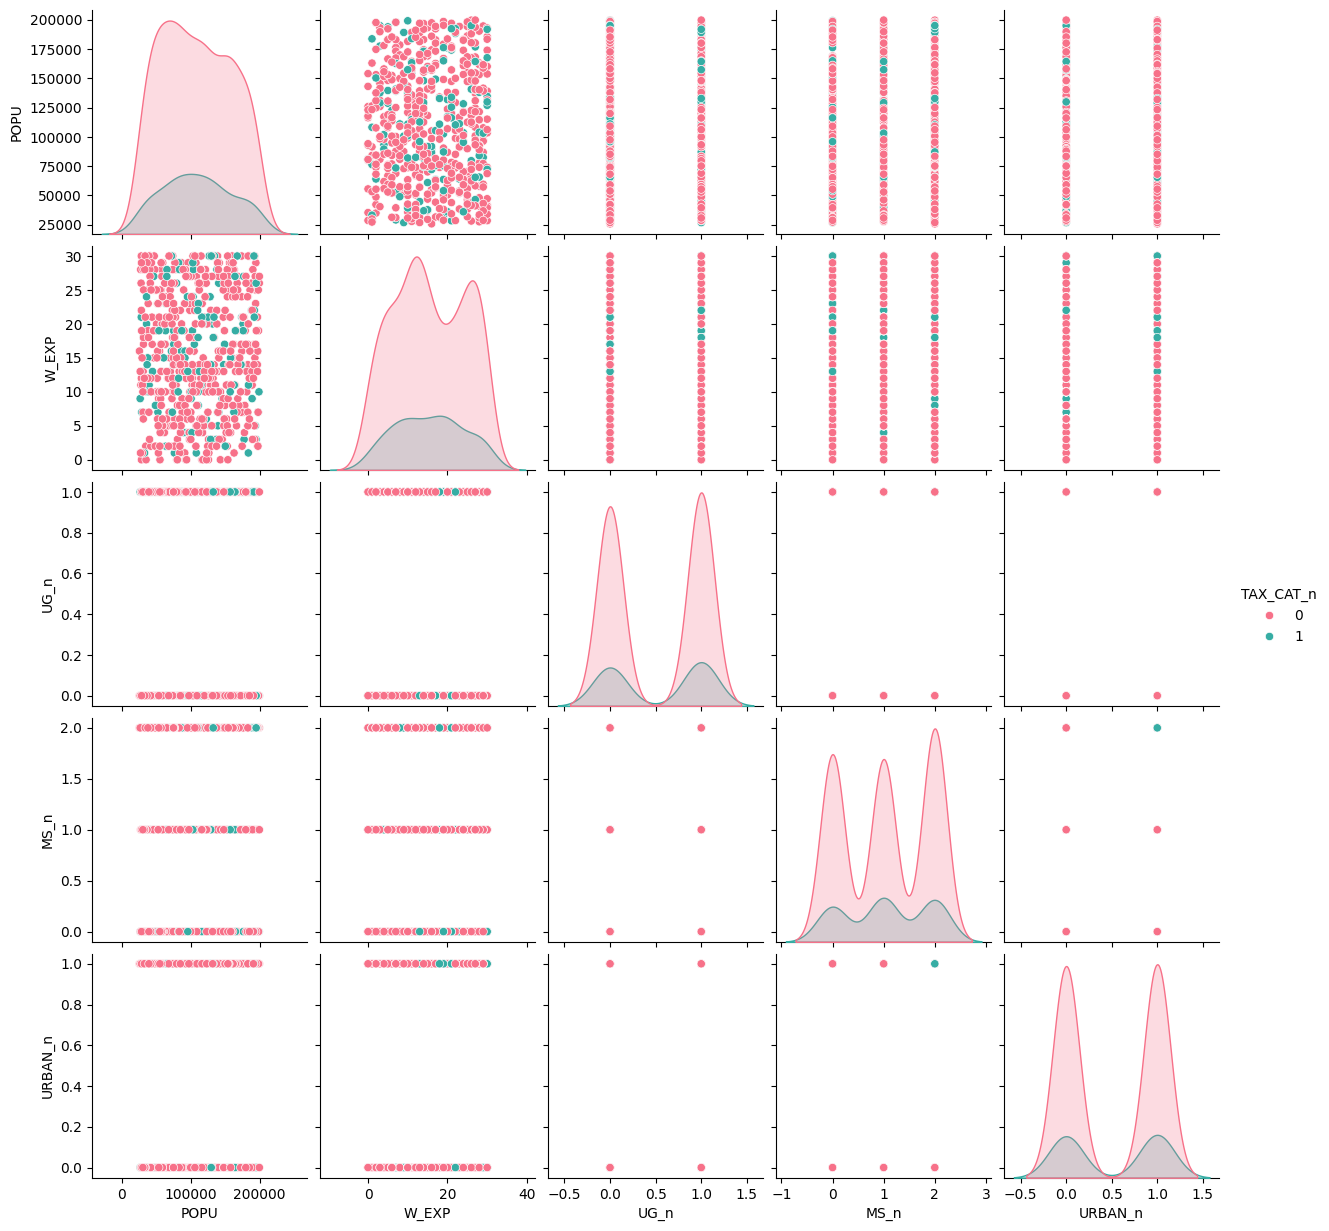

In [45]:
# Format the plot background and scatter plots for all the variables
import seaborn as sns
sns.pairplot(fr_data, hue='TAX_CAT_n', palette="husl")

Text(0.5, 1.0, "Correlation with 'Tax Categories' \n")

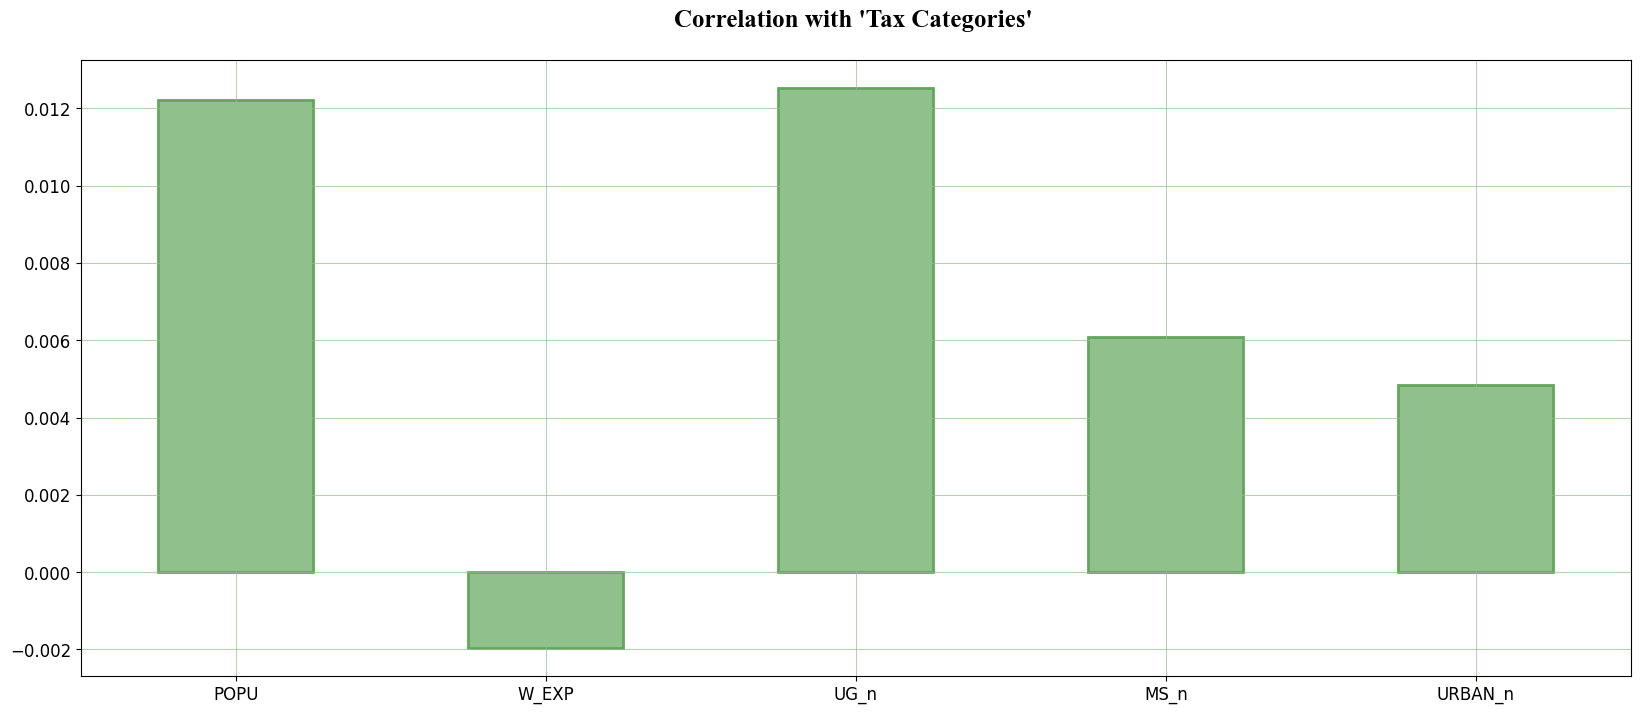

In [46]:
# Correlation with 'Tax Categories'

correlations = fr_data.corrwith(fr_data['TAX_CAT_n'])
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(figsize = (20, 8), fontsize = 12, color = '#90c08c', edgecolor = '#64a65e', linewidth = 2, grid = True)
plt.grid(color='#90c08c', linestyle='-', linewidth=0.5)
plt.xticks(rotation = 0,fontsize = 12)
plt.title('Correlation with \'Tax Categories\' \n', fontweight="bold", horizontalalignment="center", fontstyle = "normal", fontsize = "18", fontfamily = "Times New Roman")

### ***Feature Selection Technique after evaluation of scores*** ###

In [47]:
# split into input (X) and output (y) variables
fs_fraud_x = fr_data.iloc[:, :-1]
fs_fraud_y =  fr_data.TAX_CAT_n

In [48]:
fs_fraud_x.head()

,POPU,W_EXP,UG_n,MS_n,URBAN_n
0,50047,10,0,2,1
1,134075,18,1,0,1
2,160205,30,0,1,1
3,193264,15,1,2,1
4,27533,28,0,1,0


In [49]:
fs_fraud_y.head()

0    0
1    0
2    0
3    0
4    0
Name: TAX_CAT_n, dtype: int32

In [50]:
# Feature importance
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2

In [51]:
# Feature extraction
test_comp_feat = SelectKBest(score_func=chi2, k=4)
fit_comp_feat = test_comp_feat.fit(fs_fraud_x, fs_fraud_y)

In [52]:
# summarize scores
scores_comp_feat = fit_comp_feat.scores_
features_comp = fit_comp_feat.transform(fs_fraud_x)

In [53]:
score_fraud_feat_df = pd.DataFrame(list(zip(scores_comp_feat, fs_fraud_x.columns)), columns =['Score', 'Feature'])
score_fraud_feat_df.sort_values(by="Score", ascending=False, inplace=True)
score_fraud_feat_df

,Score,Feature
0,2045.643886,POPU
2,0.045165,UG_n
3,0.014298,MS_n
1,0.011709,W_EXP
4,0.006951,URBAN_n


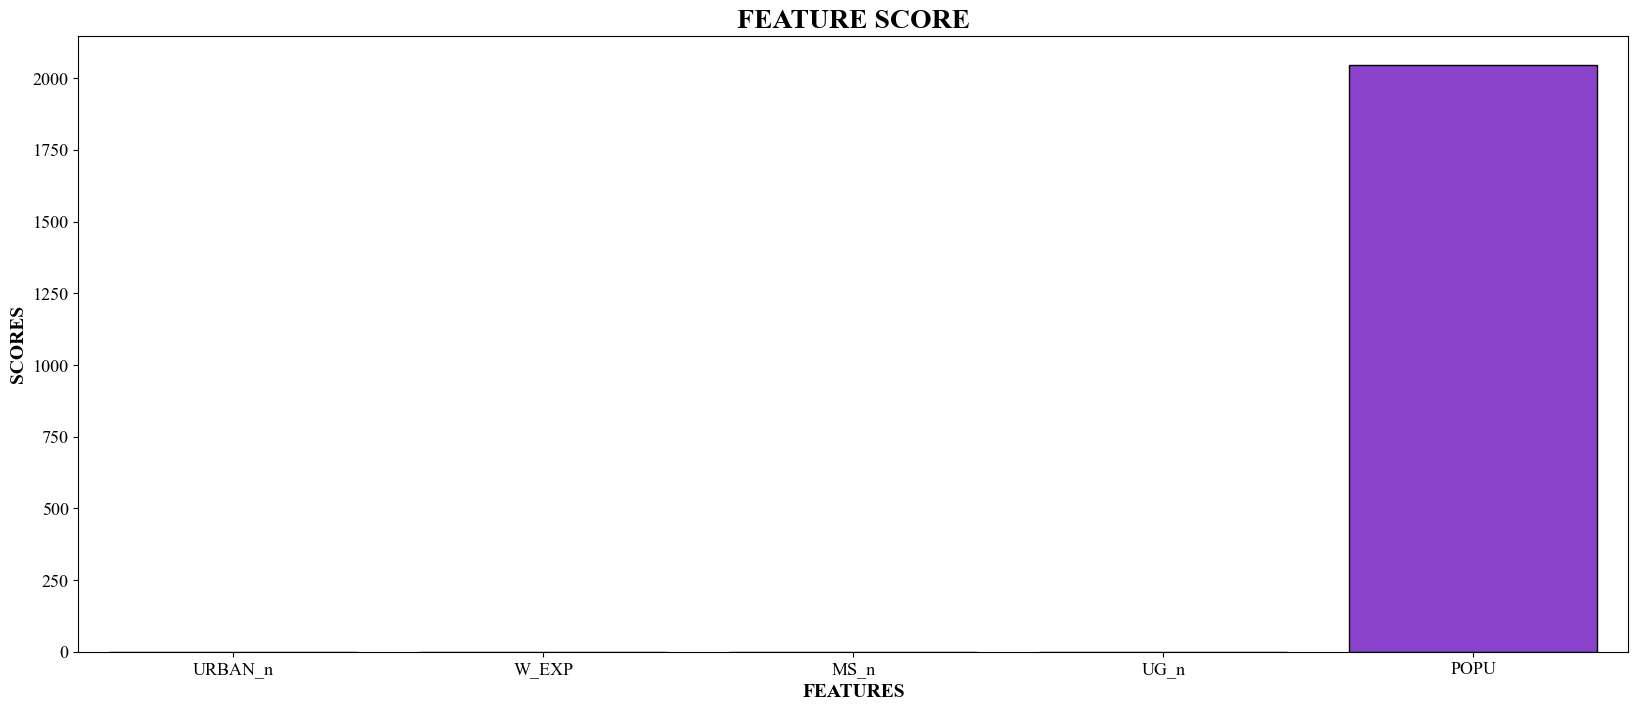

In [54]:
# Creating a chart with the Feature Score

plt.figure(figsize=(20,8))
# make barplot and sort bars
palette_color = sns.color_palette('bright')
sns.barplot(x="Feature", y="Score", data=score_fraud_feat_df, order=score_fraud_feat_df.sort_values('Score').Feature, palette=palette_color, edgecolor="#000000", linewidth=1,)
# set labels
plt.xlabel("FEATURES", size=14, weight='bold', fontfamily = "Times New Roman")
plt.ylabel("SCORES", size=14, weight='bold', fontfamily = "Times New Roman")
plt.yticks(size=13, fontfamily = "Times New Roman")
plt.xticks(size=13, fontfamily = "Times New Roman")
plt.title('FEATURE SCORE', weight='bold', fontfamily = "Times New Roman", size=20)
plt.show()

The Population is an exceptionally large value, the others are not contributing significantly. Moreover, the number of features are less so we can ignore reducing it further.

## **RANDOM FOREST** ##

In [55]:
target_fraud.value_counts()

TAX_CAT_n
0    476
1    124
Name: count, dtype: int64

We can see that the data as target value is imbalanced with the category "0: Good" is more with 476 followed by the category "1: Risky".

### **IMBALANCED DATA** ###

### ***Using GridSearchCV for tuding the Random Forest Based on the Best Parameters*** ###

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=1, n_jobs=1, max_depth=5,n_estimators=100, oob_score=True)

classifier_rf.fit(inputs_fraud, target_fraud)

# Checking the out-of-bag (OOB) score
print(f'Checking the out-of-bag (OOB) score {classifier_rf.oob_score_}')

rf = RandomForestClassifier(random_state=1, n_jobs=1)
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [5,10,25,30,50,100,200]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=params, cv = 4, n_jobs=1, verbose=1, scoring="accuracy")

grid_search.fit(inputs_fraud, target_fraud)

print('Best Score',grid_search.best_score_)

rf_best = grid_search.best_estimator_
print(rf_best)

Checking the out-of-bag (OOB) score 0.7933333333333333
Fitting 4 folds for each of 210 candidates, totalling 840 fits


Best Score 0.7933333333333333
RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=5,
                       n_jobs=1, random_state=1)


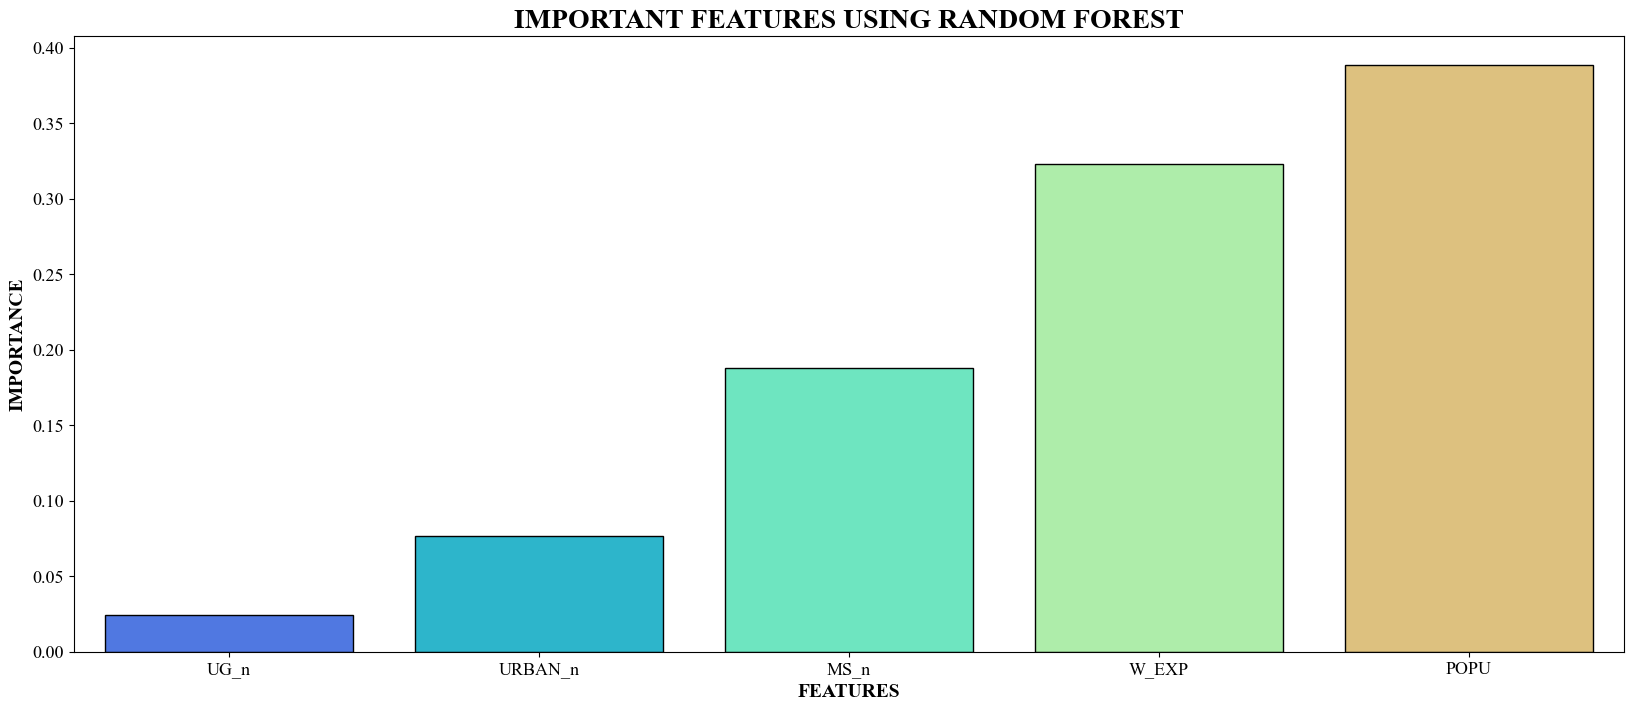

In [57]:
rf_best.feature_importances_
imp_df = pd.DataFrame({
    "Feature": inputs_fraud.columns,
    "Importance": rf_best.feature_importances_
})

plt.figure(figsize=(20,8))
# Creating a Bar Plot of the important features sorted
palette_color = sns.color_palette('rainbow')
sns.barplot(x='Feature', y="Importance", data=imp_df, order=imp_df.sort_values('Importance').Feature, palette=palette_color, edgecolor="#000000", linewidth=1,)
plt.xlabel("FEATURES", size=14, weight='bold', fontfamily = "Times New Roman")
plt.ylabel("IMPORTANCE", size=14, weight='bold', fontfamily = "Times New Roman")
plt.yticks(size=13, fontfamily = "Times New Roman")
plt.xticks(size=13, fontfamily = "Times New Roman")
plt.title("IMPORTANT FEATURES USING RANDOM FOREST", weight='bold', fontfamily = "Times New Roman", size=20)
plt.show()

In [58]:
imp_df

,Feature,Importance
0,POPU,0.388625
1,W_EXP,0.322778
2,UG_n,0.024136
3,MS_n,0.187954
4,URBAN_n,0.076507


### ***Categorizing the imbalanced data to Training and Testing Sets with testing sample size as 30%*** ###

In [59]:
# Splitting x and y into training and testing sets, testing sample size being 30%

from sklearn.model_selection import train_test_split
x_train_fraud, x_test_fraud, y_train_fraud, y_test_fraud = train_test_split(inputs_fraud, target_fraud, test_size=0.3,random_state=0,stratify=target_fraud)

In [60]:
inputs_fraud

,POPU,W_EXP,UG_n,MS_n,URBAN_n
0,50047,10,0,2,1
1,134075,18,1,0,1
2,160205,30,0,1,1
3,193264,15,1,2,1
4,27533,28,0,1,0
...,...,...,...,...,...
595,39492,7,1,0,1
596,55369,2,1,0,1
597,154058,0,0,0,1
598,180083,17,1,1,0


In [61]:
target_fraud

0      0
1      0
2      0
3      0
4      0
      ..
595    0
596    0
597    0
598    0
599    0
Name: TAX_CAT_n, Length: 600, dtype: int32

In [62]:
print("Shape of x_train_fraud: ",x_train_fraud.shape)
print("Shape of x_test_fraud: ", x_test_fraud.shape)
print("Shape of y_train_fraud: ",y_train_fraud.shape)
print("Shape of y_test_fraud: ",y_test_fraud.shape)

Shape of x_train_fraud:  (420, 5)
Shape of x_test_fraud:  (180, 5)
Shape of y_train_fraud:  (420,)
Shape of y_test_fraud:  (180,)


In [63]:
# Summarizing train and test composition
counter_train = Counter(y_train_fraud)
counter_test = Counter(y_test_fraud)
print('Training Data',counter_train,'Testing Data',counter_test)

Training Data Counter({0: 333, 1: 87}) Testing Data Counter({0: 143, 1: 37})


### ***Function to get all the details for Accuracy, Classification Report and Confustion Matrix*** ###

In [64]:
# Function to get all the metrics like Accuracy Score, ROC_AUC, Classification Report and Confusion Matrix
# based on the classification model, train and test x and y values
def print_score(clf, x_train, y_train, x_test, y_test, train=True):
    if train:
        pred = clf.predict(x_train)
        classify_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("\n**********************************************************")
        print("                  TRAINING RESULT\n**********************************************************\n")
        print(f"ACCURACY: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("\n____________________________________________________________________\n")
        print(f"ROC_AUC: {metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:, 1]) * 100:.2f}%")
        print("\n____________________________________________________________________\n")
        print(f"CLASSIFICATION REPORT:\n{classify_report}")
        print("\n____________________________________________________________________\n")
        print(f"CONFUSION MATRIX: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(x_test)
        classify_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("\n**********************************************************")
        print("                  TESTING RESULT\n**********************************************************\n")        
        print(f"ACCURACY: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("\n____________________________________________________________________\n")
        print(f"ROC_AUC: {metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1]) * 100:.2f}%")
        print("\n____________________________________________________________________\n")
        print(f"CLASSIFICATION REPORT:\n{classify_report}")
        print("\n____________________________________________________________________\n")
        print(f"CONFUSION MATRIX: \n {confusion_matrix(y_test, pred)}\n")

### **Training the Random Forest Classification Model with default parameters** ###

In [65]:
# Preparing a Random Forest model on training data set
from sklearn.ensemble import RandomForestClassifier
fraud_rf_model = RandomForestClassifier() # Here we are taking the default i.e. 100 trees
fraud_rf_model.fit(x_train_fraud, y_train_fraud)
print_score(fraud_rf_model, x_train_fraud, y_train_fraud, x_test_fraud, y_test_fraud, train=True)
print_score(fraud_rf_model, x_train_fraud, y_train_fraud, x_test_fraud, y_test_fraud, train=False)


**********************************************************
                  TRAINING RESULT
**********************************************************

ACCURACY: 100.00%

____________________________________________________________________

ROC_AUC: 100.00%

____________________________________________________________________

CLASSIFICATION REPORT:
               0     1  accuracy  macro avg  weighted avg
precision    1.0   1.0       1.0        1.0           1.0
recall       1.0   1.0       1.0        1.0           1.0
f1-score     1.0   1.0       1.0        1.0           1.0
support    333.0  87.0       1.0      420.0         420.0

____________________________________________________________________

CONFUSION MATRIX: 
 [[333   0]
 [  0  87]]


**********************************************************
                  TESTING RESULT
**********************************************************

ACCURACY: 73.89%

____________________________________________________________________



In [66]:
# Preparing a Random Forest model with 50 trees to see what is the difference in the accuracy
from sklearn.ensemble import RandomForestClassifier
fraud_rf_model_50 = RandomForestClassifier(n_estimators=50)
fraud_rf_model_50.fit(x_train_fraud, y_train_fraud)
fraud_rf_model_50.score(x_test_fraud, y_test_fraud)

# The accuracy remains at 75% despite reducing it to 50

0.7722222222222223

In [67]:
# Preparing a Random Forest model with 10 trees to see what is the difference in the accuracy
from sklearn.ensemble import RandomForestClassifier
fraud_rf_model_10 = RandomForestClassifier(n_estimators=10)
fraud_rf_model_10.fit(x_train_fraud, y_train_fraud)
fraud_rf_model_10.score(x_test_fraud, y_test_fraud)

# The accuracy has reduced to 72% by reducing the number of trees to 10

0.7555555555555555

In [68]:
# Preparing a Random Forest model with 5 trees to see what is the difference in the accuracy
from sklearn.ensemble import RandomForestClassifier
fraud_rf_model_5 = RandomForestClassifier(n_estimators=5)
fraud_rf_model_5.fit(x_train_fraud, y_train_fraud)
fraud_rf_model_5.score(x_test_fraud, y_test_fraud)

# The accuracy has surprisingly increased 73% approx by reducing the number of trees to 5

0.7111111111111111

In [69]:
# Preparing a Random Forest model with 2 trees to see what is the difference in the accuracy
from sklearn.ensemble import RandomForestClassifier
fraud_rf_model_2 = RandomForestClassifier(n_estimators=2)
fraud_rf_model_2.fit(x_train_fraud, y_train_fraud)
fraud_rf_model_2.score(x_test_fraud, y_test_fraud)

# The accuracy has 72% approx with 2 trees. So 5 trees is giving better results.

0.7166666666666667

##### **INFERENCE** #####
The accuracy is considerably good with 5 trees.

In [70]:
# Applying the best score derived by the GridSearchCV used earlier
# Best Score - RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=5, n_jobs=1, random_state=1)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

fraud_rf_model1 = RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=5, n_jobs=1, random_state=1)

fraud_rf_model1.fit(inputs_fraud, target_fraud)

RandomForestClassifier(max_depth=2, min_samples_leaf=5, n_estimators=5,
                       n_jobs=1, random_state=1)

In [71]:
print_score(fraud_rf_model1, x_train_fraud, y_train_fraud, x_test_fraud, y_test_fraud, train=True)
print_score(fraud_rf_model1, x_train_fraud, y_train_fraud, x_test_fraud, y_test_fraud, train=False)


**********************************************************
                  TRAINING RESULT
**********************************************************

ACCURACY: 79.29%

____________________________________________________________________

ROC_AUC: 61.52%

____________________________________________________________________

CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.792857   0.0  0.792857    0.396429      0.628622
recall       1.000000   0.0  0.792857    0.500000      0.792857
f1-score     0.884462   0.0  0.792857    0.442231      0.701252
support    333.000000  87.0  0.792857  420.000000    420.000000

____________________________________________________________________

CONFUSION MATRIX: 
 [[333   0]
 [ 87   0]]


**********************************************************
                  TESTING RESULT
**********************************************************

ACCURACY: 79.44%

__________________________________________

In [72]:
# Making predictions on the testing set
fraud_y_pred1 = fraud_rf_model1.predict(x_test_fraud)
fraud_y_pred1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [73]:
pd.crosstab(y_test_fraud,fraud_y_pred1) # getting the 2 way table to understand the correct and wrong predictions. Actual 0 - but it is predicted as 1

col_0,0
TAX_CAT_n,
0,143
1,37


In [74]:
# Calculation based on the 2 way matrix table
diag_1 = np.trace(pd.crosstab(y_test_fraud,fraud_y_pred1))
total_1 = sum(pd.crosstab(y_test_fraud,fraud_y_pred1).sum())
acc_1 = diag_1/total_1
print(f"The calculation done on the 2 way matrix table -\nThe sum of diagonal elements is {diag_1} and total elements is {total_1} and accuracy is {acc_1}") 

The calculation done on the 2 way matrix table -
The sum of diagonal elements is 143 and total elements is 180 and accuracy is 0.7944444444444444


*Checking accuracy using Metrics*

In [75]:
# Checking accuracy by comparing actual response values (y_test_fraud) with predicted
# response values (fraud_y_pred)
from sklearn import metrics
fraud_score = metrics.accuracy_score(y_test_fraud,fraud_y_pred1)
print("Accuracy using metrics:", fraud_score)

Accuracy using metrics: 0.7944444444444444


*Checking accuracy using Alternate Method*

In [76]:
# Checking accuracy using alternate method
fraud_score_alt = fraud_rf_model1.score(x_test_fraud, y_test_fraud)
print("Accuracy using alternate method:", fraud_score_alt)

Accuracy using alternate method: 0.7944444444444444


In [77]:
# Accuracies for both Training and Testing Samples
from sklearn import metrics
training_acc_fraud1 = metrics.accuracy_score(y_train_fraud, fraud_rf_model1.predict(x_train_fraud))
testing_acc_fraud1 = metrics.accuracy_score(y_test_fraud, fraud_rf_model1.predict(x_test_fraud))
print(f"Accuracy using metrics-\nTraining Accuracy: {training_acc_fraud1}\nTesting Accuracy: {testing_acc_fraud1}")

Accuracy using metrics-
Training Accuracy: 0.7928571428571428
Testing Accuracy: 0.7944444444444444


In [78]:
# Checking the ROC_AUC
from sklearn.tree import DecisionTreeClassifier
roc_auc_fraud1 = metrics.roc_auc_score(y_test_fraud, fraud_rf_model1.predict_proba(x_test_fraud)[:, 1])
print(f"The ROC_AUC value is {roc_auc_fraud1}")

The ROC_AUC value is 0.6321111321111321


*Confusion Matrix*

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

The sum of diagonal elements is 143 and total elements is 180 and manually calculated score is 0.7944444444444444

The metrics accuracy score calculated is - 0.7944444444444444

Both the scores match.



col_0,0
TAX_CAT_n,
0,143
1,37


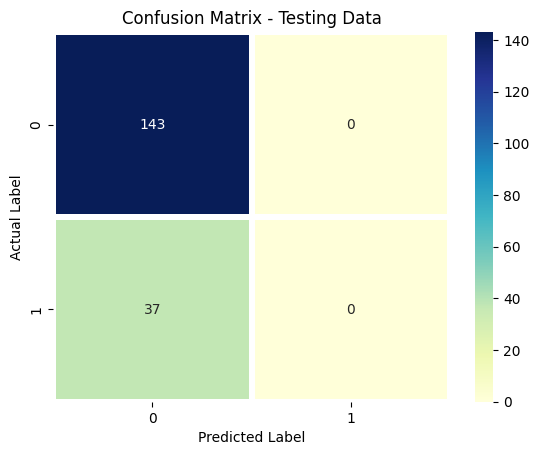

In [79]:
# Confustion Matrix
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Making predictions on the testing set
fraud_y_pred1 = fraud_rf_model1.predict(x_test_fraud)

pd.Series(fraud_y_pred1).value_counts() # getting the count of each category
print(fraud_y_pred1)
classnames = ['0','1']
confusionmatrix1 = confusion_matrix(y_test_fraud,fraud_y_pred1)
sns.heatmap(confusionmatrix1,annot=True,yticklabels=classnames,xticklabels=classnames,fmt='d',cmap="YlGnBu",linewidths=3)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Testing Data")



diag_fraud = np.trace(confusionmatrix1)
total_fraud = sum(sum(confusionmatrix1))
maccs = diag_fraud/total_fraud
print(f"\nThe sum of diagonal elements is {diag_fraud} and total elements is {total_fraud} and manually calculated score is {maccs}\n") 

mascore = metrics.accuracy_score(y_test_fraud, fraud_y_pred1)
print(f"The metrics accuracy score calculated is - {mascore}\n")
print("Both the scores match.\n")

pd.crosstab(y_test_fraud,fraud_y_pred1) # getting the 2 way table to understand the correct and wrong predictions. Actual 0 - but it is predicted as 1

### ***Using RandomizedSearchCV for tuning the Random Forest Based on the Best Parameters*** ###

In [117]:
# Tuning parameters through randomized search cross-validation
from sklearn.model_selection import RandomizedSearchCV

random_grid = [
    {'n_estimators': [5,10,25,30,50,100], 'criterion': ["entropy","gini"], 'max_features': ['auto','sqrt','log2'],
    'max_depth': [2,3,5,10,20], 'bootstrap': [True, False], 'min_samples_leaf': [5,10,20,50,100,200],}
]
classifier = RandomForestClassifier(n_estimators=100)
random_search_forest = RandomizedSearchCV(classifier, random_grid, n_iter = 100, cv = 4, scoring='accuracy', verbose=1, random_state=42)
random_search_forest.fit(x_train_fraud, y_train_fraud)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions=[{'bootstrap': [True, False],
                                         'criterion': ['entropy', 'gini'],
                                         'max_depth': [2, 3, 5, 10, 20],
                                         'max_features': ['auto', 'sqrt',
                                                          'log2'],
                                         'min_samples_leaf': [5, 10, 20, 50,
                                                              100, 200],
                                         'n_estimators': [5, 10, 25, 30, 50,
                                                          100]}],
                   random_state=42, scoring='accuracy', verbose=1)

*Choosing the Best Parameters*

In [81]:
# Finding the best parameters
random_search_forest.best_params_

{'n_estimators': 50,
 'min_samples_leaf': 20,
 'max_features': 'sqrt',
 'max_depth': 3,
 'criterion': 'gini',
 'bootstrap': False}

*Tuning the Random Forest Based on the Best Parameters*

In [82]:
# Tuning the random forest based on the best parameters
tunedclassifier = RandomForestClassifier(n_estimators= 50, min_samples_leaf = 20, max_features = 'sqrt', max_depth = 3, criterion = 'gini', bootstrap = False)
tunedclassifier.fit(x_train_fraud,y_train_fraud)

RandomForestClassifier(bootstrap=False, max_depth=3, min_samples_leaf=20,
                       n_estimators=50)

*Predicting using the training data*

In [83]:
# Prediction using training data
fraud_pred_train_y = tunedclassifier.predict(x_train_fraud)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Text(0.5, 1.0, 'Confusion Matrix - Training Data')

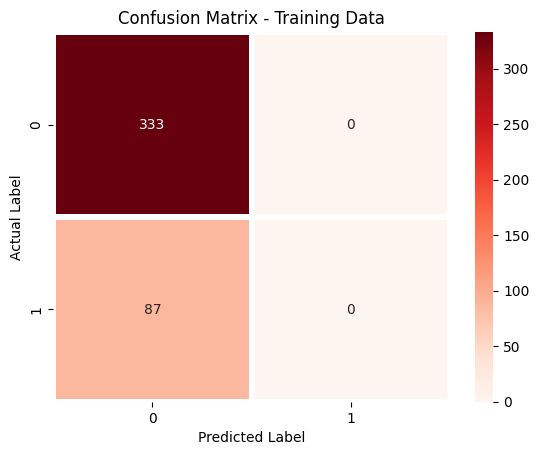

In [84]:
pd.Series(tunedclassifier.predict(x_train_fraud)).value_counts() # getting the count of each category
print(fraud_y_pred1)
classnames = ['0','1']
confusionmatrix1 = confusion_matrix(y_train_fraud,tunedclassifier.predict(x_train_fraud))
sns.heatmap(confusionmatrix1,annot=True,yticklabels=classnames,xticklabels=classnames,fmt='d',cmap="Reds",linewidths=3)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Training Data")

*Accuracy*

In [85]:
from sklearn import metrics
print(f"Accuracy: {metrics.accuracy_score(y_train_fraud,tunedclassifier.predict(x_train_fraud))}")

Accuracy: 0.7928571428571428


Since this model does not show a 100% accuracy, this model is not perfect for prediction. This is because the model predicts the majority of the target class 

*Prediction using Testing Data*

In [86]:
# Prediction using test data
fraud_y_predict = tunedclassifier.predict(x_test_fraud)

*Model performance on testing data*

Text(0.5, 1.0, 'Confusion Matrix - Training Data')

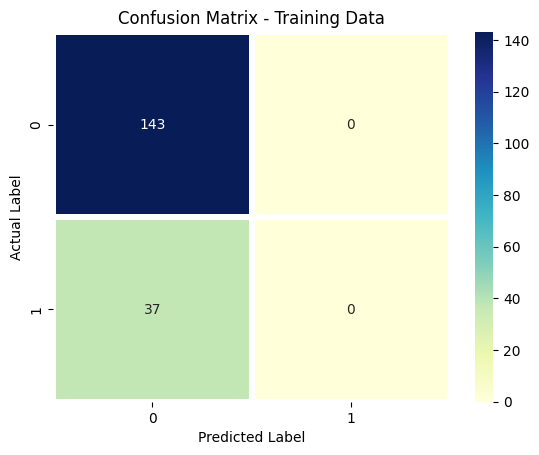

In [87]:
classnames = ['0','1']
confusionmatrix1 = confusion_matrix(y_test_fraud,tunedclassifier.predict(x_test_fraud))
sns.heatmap(confusionmatrix1,annot=True,yticklabels=classnames,xticklabels=classnames,fmt='d',cmap="YlGnBu",linewidths=3)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Training Data")

##### **INFERENCE** #####
- The best accuracy is for the model 'fraud_rf_model1' i.e., 79.44%
- As a result of the imbalance in the target dataset,the results are biased towards the majority class.
- This will classify the target majority classes correctly but will fail to classify the target minority classes.
- We will need to use some kind of oversampling techniques to balance the dataset.

### **BALANCING THE DATA** ###

In [88]:
fr_data

,POPU,W_EXP,UG_n,MS_n,URBAN_n,TAX_CAT_n
0,50047,10,0,2,1,0
1,134075,18,1,0,1,0
2,160205,30,0,1,1,0
3,193264,15,1,2,1,0
4,27533,28,0,1,0,0
...,...,...,...,...,...,...
595,39492,7,1,0,1,0
596,55369,2,1,0,1,0
597,154058,0,0,0,1,0
598,180083,17,1,1,0,0


In [89]:
fr_data.TAX_CAT_n.value_counts()

TAX_CAT_n
0    476
1    124
Name: count, dtype: int64

In [90]:
inputs_f = fr_data.iloc[:,0:5]
target_f = fr_data.iloc[:,5]

In [91]:
inputs_f

,POPU,W_EXP,UG_n,MS_n,URBAN_n
0,50047,10,0,2,1
1,134075,18,1,0,1
2,160205,30,0,1,1
3,193264,15,1,2,1
4,27533,28,0,1,0
...,...,...,...,...,...
595,39492,7,1,0,1
596,55369,2,1,0,1
597,154058,0,0,0,1
598,180083,17,1,1,0


In [92]:
target_f

0      0
1      0
2      0
3      0
4      0
      ..
595    0
596    0
597    0
598    0
599    0
Name: TAX_CAT_n, Length: 600, dtype: int32

In [93]:
from sklearn.model_selection import train_test_split
x_train_f, x_test_f,y_train_f,y_test_f = train_test_split(inputs_f, target_f, test_size=0.3, random_state=0, stratify=target_f)

In [94]:
target_f.value_counts()
# The counts are imbalanced for the total count of 600 records.

TAX_CAT_n
0    476
1    124
Name: count, dtype: int64

In [95]:
y_train_f.value_counts()
# The counts are imbalanced for the training count of 480 records, which is 80% of the total 600 records.
# We see that the "Good: 0" has a higher count with 378 when compared to "Risky: 1" has the lowest count with 102

TAX_CAT_n
0    333
1     87
Name: count, dtype: int64

In [96]:
print("Shape of x_train_f: ",x_train_f.shape)
print("Shape of x_test_f: ", x_test_f.shape)
print("Shape of y_train_f: ",y_train_f.shape)
print("Shape of y_test_f: ",y_test_f.shape)

Shape of x_train_f:  (420, 5)
Shape of x_test_f:  (180, 5)
Shape of y_train_f:  (420,)
Shape of y_test_f:  (180,)


### **SMOTE: Synthetic Minority Oversampling Technique** ###

In [97]:
# Using SMOTE to balance the data using Oversampling technique. 

from collections import Counter
from imblearn.over_sampling import SMOTE,  ADASYN
counter_f = Counter(y_train_f)
print('Before',counter_f)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_fsm, y_train_fsm = smt.fit_resample(x_train_f, y_train_f)

counter_f = Counter(y_train_fsm)
print('After',counter_f)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


In [98]:
y_train_fsm.value_counts()
# After applying SMOTE, the counts have balanced for the training count of 378 records, which is 80% of the total 600 records.
# We now see that "Good: 0" and , "Low: 0" and "Risky: 1", all have the same count of records i.e., 378

TAX_CAT_n
0    333
1    333
Name: count, dtype: int64

### **ADASYN: Adaptive Synthetic Sampling Approach** ###

In [99]:
# Using ADASYN to balance the data using Oversampling technique. 
from collections import Counter
from imblearn.over_sampling import SMOTE,  ADASYN
counter_f = Counter(y_train_f)
print('Before',counter_f)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_fada, y_train_fada = ada.fit_resample(x_train_f, y_train_f)

counter_f = Counter(y_train_fada)
print('After',counter_f)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


### **Analyzing the Performance after Oversampling to Balance the target class** ###

#### ***Function to get all the necessary metrics*** ####

*Function to get - confusion matrix, classification report, f1_score, recall score, precision score for given model and parameter values provided*

In [100]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

# Function to give the confusion matrix, classification report, f1_score, recall score, precision score for given model and parameter values provided

def test_eval(clf_model, x_test, y_test, algo=None, sampling=None):
    
    # Getting the Prediction probability and prediction values for Test Set
    y_prob=clf_model.predict_proba(x_test)
    y_pred=clf_model.predict(x_test)
    print('_'*60)
    print('\nCONFUSION MATRIX')
    print(confusion_matrix(y_test,y_pred))
    print('_'*60)
    
    # Calculating the Accuracy
    diag_f = np.trace(confusion_matrix(y_test,y_pred))
    total_f = sum(sum(confusion_matrix(y_test,y_pred)))
    maccs_f = diag_f/total_f
    print(f"\nACCURACY: {maccs_f}\n") 

    # Calculating the ROC_AUC
    from sklearn.tree import DecisionTreeClassifier
    roc_auc_f = metrics.roc_auc_score(y_test, clf_model.predict_proba(x_test)[:, 1])
    print(f"ROC_AUC: {roc_auc_f}\n")
    print('_'*60)


    print(f"\nCLASSIFICATION REPORT")
    print('-'*60)
    print(classification_report(y_test,y_pred))
    print('-'*60)
    print('_'*60)
    f1 = f1_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
          
    
    return algo,precision,recall,f1,sampling

In [101]:
# Getting the necessary details i.e., confusion matrix, classification report, f1_score, recall score, precision score for given model and parameter values provided

model_params = {
    'random_forest' :{
        'model' :  RandomForestClassifier(),
        'params' : {
             "n_estimators": [5, 10, 15, 20, 25], 
             'max_depth': [2, 3, 5, 10, 16, 20],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100, 200],
             'criterion': ['gini', 'entropy'],
             'max_features': [10]
        }
        
    }
}

sampled_data = {
    'ACTUAL':[x_train_f, y_train_f],
    'SMOTE':[x_train_fsm, y_train_fsm],
    'ADASYN':[x_train_fada, y_train_fada]
}

cv = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
output = []
for model , model_hp in model_params.items():
    for resam , data in sampled_data.items():
        clf = RandomizedSearchCV(model_hp['model'], model_hp['params'],cv = cv, scoring='roc_auc', n_jobs=-1)
        clf.fit(data[0], data[1])
        clf_best = clf.best_estimator_
        print("\n\n",' '*7, f"USING {model.upper()} WITH {resam.upper()}")
        print('_'*60)
        output.append(test_eval(clf_best, x_test_f, y_test_f, model, resam))



         USING RANDOM_FOREST WITH ACTUAL
____________________________________________________________
____________________________________________________________

CONFUSION MATRIX
[[143   0]
 [ 37   0]]
____________________________________________________________

ACCURACY: 0.7944444444444444

ROC_AUC: 0.4483084483084483

____________________________________________________________

CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180

------------------------------------------------------------
____________________________________________________________


         USING RANDOM_FOREST WITH SMOTE
_____________________________________

##### **INFERENCE** #####
Based on the details, we can see that the ADASYN technique gives the best results and so we can go for it.

In [102]:
fraud_final_model = DecisionTreeClassifier(max_depth=13, max_features=10, min_samples_leaf=5, min_samples_split=20)
x_train_ffinal,x_test_ffinal,y_train_ffinal,y_test_ffinal = train_test_split(x_train_fada,y_train_fada,test_size=0.3,random_state=0, stratify=y_train_fada)
fraud_final_model.fit(x_train_ffinal, y_train_ffinal)

DecisionTreeClassifier(max_depth=13, max_features=10, min_samples_leaf=5,
                       min_samples_split=20)

In [103]:
final_confusion_matrix = confusion_matrix(y_test_ffinal,fraud_final_model.predict(x_test_ffinal))
final_confusion_matrix

array([[62, 38],
       [24, 74]], dtype=int64)

In [104]:
# Checking accuracy by comparing actual response values (y_test_ffinal) with predicted
# response values (prediction for y)
from sklearn import metrics
final_fraud_score = metrics.accuracy_score(y_test_ffinal,fraud_final_model.predict(x_test_ffinal))
print("Accuracy using metrics:", final_fraud_score)

Accuracy using metrics: 0.6868686868686869


In [105]:
# Checking accuracy using alternate method
final_fraud_score = fraud_final_model.score(x_test_ffinal, y_test_ffinal)
print("Accuracy using alternate method:", final_fraud_score)

Accuracy using alternate method: 0.6868686868686869


### **Random Forest hyperparameter tuning** ###

In [106]:
score_array = []
for each in range(1,200):
    fraud_rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1) 
    fraud_rf_loop.fit(x_train_fraud,y_train_fraud)
    score_array.append(fraud_rf_loop.score(x_train_fraud,y_train_fraud))

In [107]:
loc = np.array(score_array).max()
score_array.index(loc)+1

39

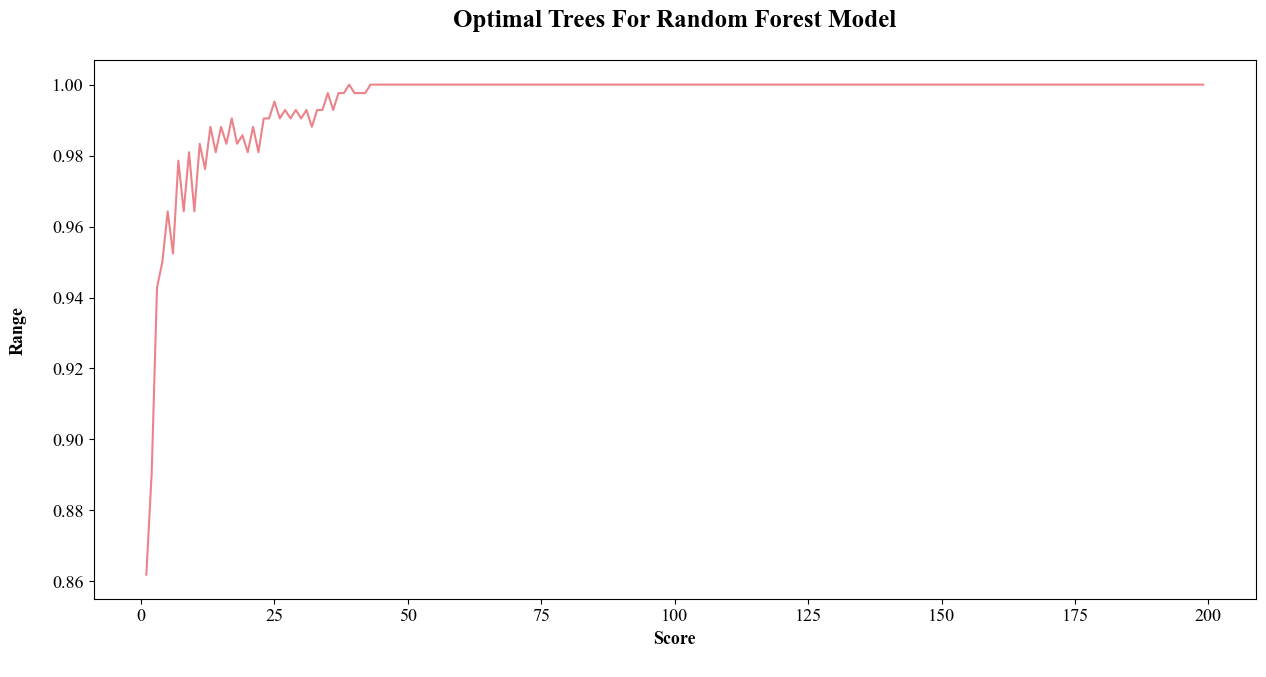

In [108]:
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,200),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center", fontstyle = "normal", weight='bold', fontfamily = "Times New Roman", size = '13')
plt.xlabel('Score\n',horizontalalignment="center", fontstyle = "normal", weight='bold', fontfamily = "Times New Roman", size = '13')
plt.title('Optimal Trees For Random Forest Model\n',horizontalalignment="center", fontsize = "22", weight='bold', fontfamily = "Times New Roman", size = '18')
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center", fontfamily = "Times New Roman", size = '13')
plt.yticks(rotation=0, horizontalalignment="right", fontfamily = "Times New Roman", size = '13')
plt.show()

##### **a) Grid Search Cross Validation** #####

In [109]:
# Create a pipeline with a Random forest classifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from time import time
    
pipe_rfc = Pipeline([ 
  ('scl', StandardScaler()), 
  ('rfc', RandomForestClassifier(random_state=0, n_jobs=-1) )
  ])

# Set the grid parameters
param_grid_rfc = [{
  'rfc__n_estimators': [100, 200,300,400], # number of estimators
  #'rfc__criterion': ['gini', 'entropy'],   # Splitting criterion
  'rfc__max_features':[0.05 , 0.1], # maximum features used at each split
  'rfc__max_depth': [None, 5], # Max depth of the trees
  'rfc__min_samples_split': [0.005, 0.01], # mininal samples in leafs
  }]

# Using 10 fold CV
kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state= 0)
grid_rfc = GridSearchCV(pipe_rfc, param_grid= param_grid_rfc, cv=kfold, scoring='f1', verbose= 1, n_jobs=-1)

start = time()
grid_rfc = grid_rfc.fit(x_train_ffinal, y_train_ffinal)
end = time()
print("\n____________________________________________________________________\n")
print("RFC grid search took %.3f seconds" %(end-start))
# Best score and best parameters
print("\n____________________________________________________________________\n")
print(f"BEST SCORE: {grid_rfc.best_score_ * 100.0}")
print("\n____________________________________________________________________\n")
print(f"BEST PARAMETERS: {grid_rfc.best_params_})")
print("\n____________________________________________________________________\n")

print_score(grid_rfc, x_train_ffinal, y_train_ffinal, x_test_ffinal, y_test_ffinal, train=True)
print_score(grid_rfc, x_train_ffinal, y_train_ffinal, x_test_ffinal, y_test_ffinal, train=False)

Fitting 10 folds for each of 32 candidates, totalling 320 fits

____________________________________________________________________

RFC grid search took 68.523 seconds

____________________________________________________________________

BEST SCORE: 71.32682415415034

____________________________________________________________________

BEST PARAMETERS: {'rfc__max_depth': None, 'rfc__max_features': 0.05, 'rfc__min_samples_split': 0.005, 'rfc__n_estimators': 100})

____________________________________________________________________


**********************************************************
                  TRAINING RESULT
**********************************************************

ACCURACY: 99.78%

____________________________________________________________________

ROC_AUC: 100.00%

____________________________________________________________________

CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.995652  

##### **b) Randomized Search Cross Validation** #####

In [110]:
n_estimators = [int(x) for x in np.linspace(start=0, stop=200, num=200)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_clf = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='f1',param_distributions=random_grid, n_iter=100, cv=3, 
                               verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(x_train_ffinal, y_train_ffinal)
rf_best_params = rf_cv.best_params_

print("\n____________________________________________________________________\n")
print(f"BEST SCORE: {rf_cv.best_score_}")
print("\n____________________________________________________________________\n")
print(f"BEST PARAMETERS: {rf_best_params})")
print("\n____________________________________________________________________\n")

rf_clf = RandomForestClassifier(**rf_best_params)
rf_clf.fit(x_train_ffinal, y_train_ffinal)

print_score(rf_clf, x_train_ffinal, y_train_ffinal, x_test_ffinal, y_test_ffinal, train=True)
print_score(rf_clf, x_train_ffinal, y_train_ffinal, x_test_ffinal, y_test_ffinal, train=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits



____________________________________________________________________

BEST SCORE: 0.6671056585885212

____________________________________________________________________

BEST PARAMETERS: {'n_estimators': 148, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False})

____________________________________________________________________


**********************************************************
                  TRAINING RESULT
**********************************************************

ACCURACY: 94.37%

____________________________________________________________________

ROC_AUC: 98.52%

____________________________________________________________________

CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.940426    0.947137  0.943723    0.943781      0.943752
recall       0.948498    0.938865  0.943723    0.943681      0.943723
f1-score     0.944444    0.942982  0.943723   

### **Visualizing one of the decision tree in random forest** ###

In [111]:
rf_best = rf_cv.best_estimator_
rf_best

RandomForestClassifier(bootstrap=False, max_depth=70, min_samples_leaf=4,
                       min_samples_split=5, n_estimators=148, random_state=42)

In [112]:
fraud_data.TAX_CAT.unique()

['Good', 'Risky']
Categories (2, object): ['Risky' < 'Good']

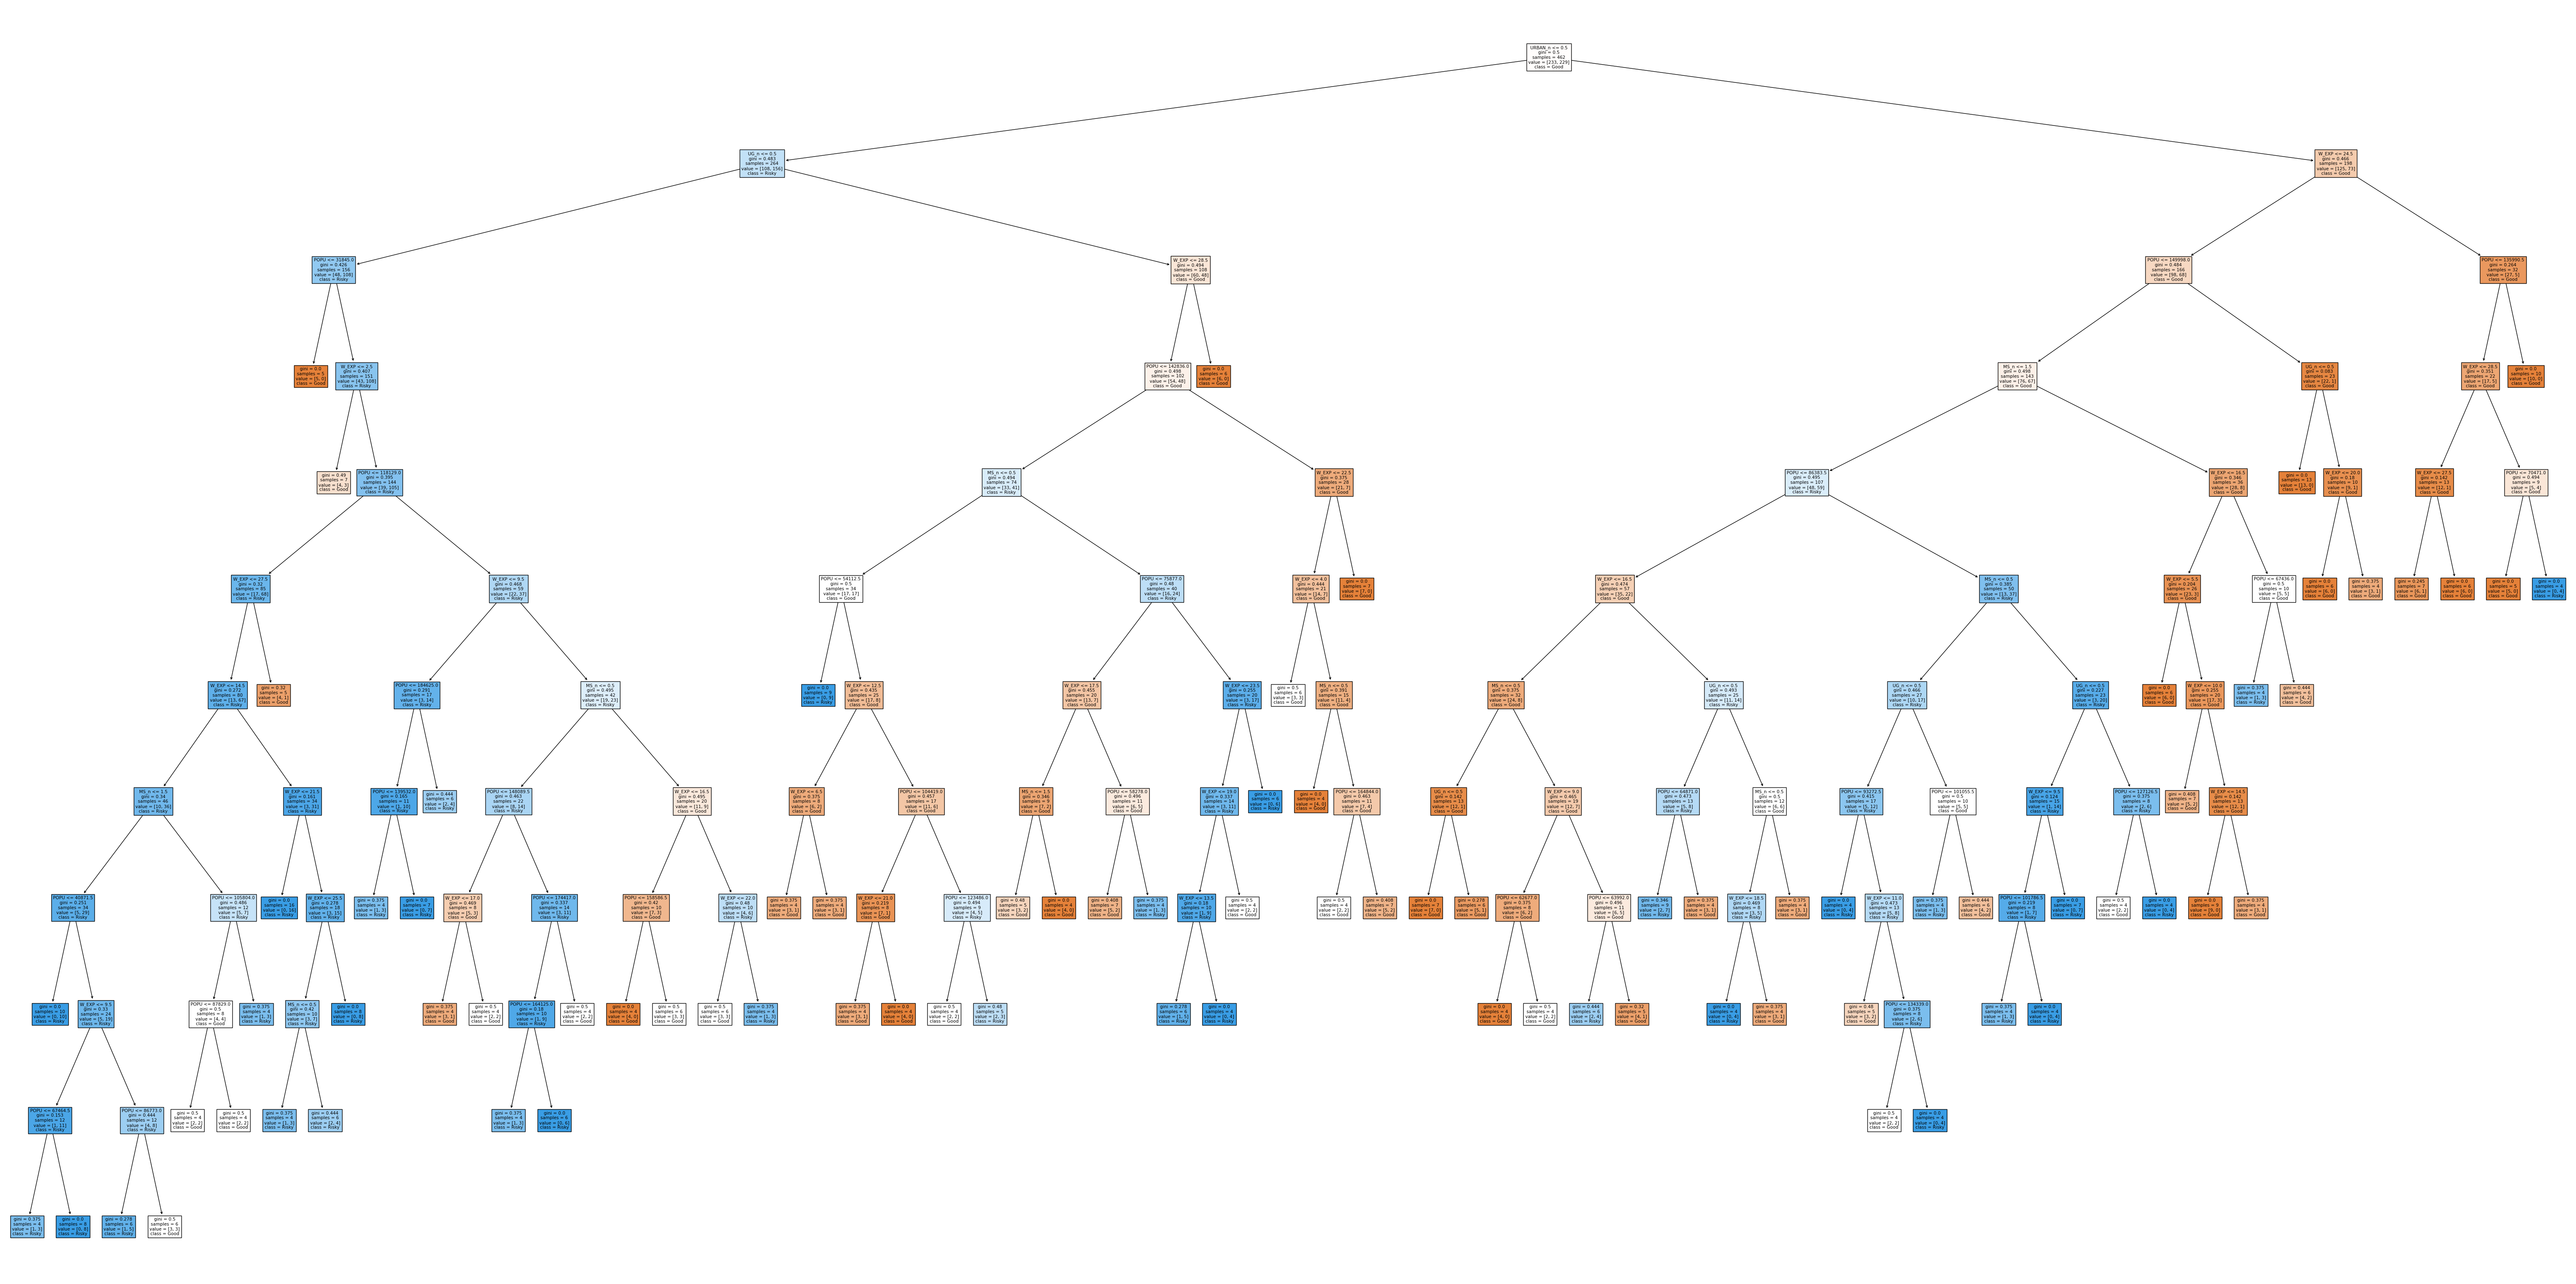

In [113]:
from sklearn.tree import plot_tree
plt.figure(figsize=(80,40))
plot_tree(rf_best.estimators_[59], feature_names = fr_data.columns,class_names=fraud_data.TAX_CAT.unique(),filled=True)
plt.show()

### **PREDICTIONS BASED ON A MODEL** ###

In [114]:
# The original model created takes into consideration 10 features/colums for prediction of the Fraud i.e. "Good - 0" and "Risky - 1"
prediction = fraud_rf_model1.predict([['184704','2','1','0','0'],['110892','18','1','2','1'],['58535','20','1','2','1'],['148391','12','0','0','0'],['179299','6','0','0','0'],['183911','9','0','1','0'],['112659','14','1','0','0'],['28542','12','1','2','1'],['124606','27','0','0','1'],['75169','28','0','1','0']])
print(f"The predication based on model are: {prediction[0], prediction[1], prediction[2], prediction[3], prediction[4], prediction[5],prediction[6], prediction[7], prediction[8], prediction[9]}")

# Note: This prediction is not exactly **correct** but most match as these are records with index nos 613, 74, 34, 520, 580, 579, 29, 5, 16 and 134 respectively.

The predication based on model are: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


In [115]:
# The final model created takes into consideration 10 features/colums for prediction of the Fraud i.e. "Good - 0" and "Risky - 1"
prediction_final = fraud_final_model.predict([['184704','2','1','0','0'],['110892','18','1','2','1'],['58535','20','1','2','1'],['148391','12','0','0','0'],['179299','6','0','0','0'],['183911','9','0','1','0'],['112659','14','1','0','0'],['28542','12','1','2','1'],['124606','27','0','0','1'],['75169','28','0','1','0']])
print(f"The predication based on model are: {prediction_final[0], prediction_final[1], prediction_final[2], prediction_final[3], prediction_final[4], prediction_final[5],prediction_final[6], prediction_final[7], prediction_final[8], prediction_final[9]}")

# Note: This prediction is not exactly **correct** but most match as these are records with index nos 613, 74, 34, 520, 580, 579, 29, 5, 16 and 134 respectively.

The predication based on model are: (0, 0, 1, 1, 1, 1, 0, 0, 0, 1)


In [116]:
# The best model created takes into consideration 10 features/colums for prediction of the Fraud i.e. "Good - 0" and "Risky - 1"
prediction_best_model = rf_best.predict([['184704','2','1','0','0'],['110892','18','1','2','1'],['58535','20','1','2','1'],['148391','12','0','0','0'],['179299','6','0','0','0'],['183911','9','0','1','0'],['112659','14','1','0','0'],['28542','12','1','2','1'],['124606','27','0','0','1'],['75169','28','0','1','0']])
print(f"The predication based on model are: {prediction_best_model[0], prediction_best_model[1], prediction_best_model[2], prediction_best_model[3], prediction_best_model[4], prediction_best_model[5],prediction_best_model[6], prediction_best_model[7], prediction_best_model[8], prediction_best_model[9]}")

# Note: This prediction is absolutelyy **correct** and matches all the records with index nos 613, 74, 34, 520, 580, 579, 29, 5, 16 and 134 respectively.

The predication based on model are: (1, 1, 1, 1, 1, 1, 0, 0, 0, 0)


##### **INFERENCE** #####
- The original model gives a good prediction of the majority class i.e., the "0: Good" but fails to predict the minority class i.e., "1: Risky"
- By balancing the data(using the ADASYN technique), we get more correct predictions of the minority target class as well, when compared to the original model. We get almost 70% correct predictions using the balancing technique clubbed with Random Forest Classification Model Prediction. However, this was not the best model.
- The best model "rf_best" by searching for the best model using Randomized Search Cross Validation in Random Forest gives us the perfect model predictions with all correct results of predictions
